In [2]:
%load_ext autoreload
%autoreload 2

import json
import pickle
import os
import math
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import entropy
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator

from scipy import stats
from scipy.stats import spearmanr, pearsonr
from pingouin import ttest
from scipy.stats import sem



def stable_softmax(x, temp):
    x = np.array(x)
    z = x - max(x)
    numerator = np.exp(z/temp)
    denominator = np.sum(numerator)
    softmax = numerator/denominator

    return softmax

In [3]:
# filter display info using expimg ids 
DIR_STIMULI = '../exp-source/exp_datasource/screen_images/'

# load fixation data
with open('search-gaze-roiadded-clean.json') as f:
    fdictlist = json.load(f)

subject_ids = np.unique([fd['SUBJECT_ID'] for fd in fdictlist])
print(f"# of subjects: {len(subject_ids)}")

# load stimuli info with model priority
display_info =  np.load('../exp-source/display_info.npy', allow_pickle=True)
#print('# of all stimuli: ', len(display_info))
stimuli_ids = list(np.unique([fd['IMAGE_ID'] for fd in fdictlist]))
print('# of exp stimuli', len(stimuli_ids))

stimuli_info = [list(filter(lambda x: x['display_idx'] == imgid, display_info))[0] for imgid in stimuli_ids]
filenames = [stim['display_filename'] for stim in stimuli_info]
d_imgid2imgfilename = dict(zip(stimuli_ids , filenames))

# Map target categories to image IDs
TARGET_CATEGORIES = ['dog', 'bird', 'insect', 'turtle']
d_target2imgid = {}
for target in TARGET_CATEGORIES:
    target_trials = [trial for trial in stimuli_info if trial['target_label'] == target]
    print(f'{target} -- # of trials: {len(target_trials)}')
    d_target2imgid[target] = [trial['display_idx'] for trial in target_trials]


# load model results and add them to stim info
IMAGE_TYPE = 'clean'
cnn_results =  np.load(f'../exp-source/template_results_{IMAGE_TYPE}.npy', allow_pickle=True)
our_results =  np.load(f'../exp-source/our_results_{IMAGE_TYPE}.npy', allow_pickle=True)
for stim in stimuli_info:
    cres = list(filter(lambda x: x['display_idx']==stim['display_idx'], cnn_results))[0]
    ores = list(filter(lambda x: x['display_idx']==stim['display_idx'], our_results))[0]
    stim['cnn_search_acc'] = cres['acc']
    stim['our_search_acc'] = ores['acc']
    stim['cnn_priority_raw'] =  list(-(np.array(cres['L2norm']))) 
    stim['our_priority_raw'] = list(-(np.array(ores['budget_usage']))) 

    # stim['cnn_entropy'] =  entropy(stim['cnn_priority']) #cres['entropy']
    # stim['our_entropy'] = entropy(stim['our_priority'] )# ores['entropy'] 

GC_BUDGET = 40

cnn_priority_raw_list = []
for info in stimuli_info:
    cnn_priority_raw_list.extend(list(info['cnn_priority_raw']))
print('l2 template matching distance max and min', np.max(cnn_priority_raw_list), np.min(cnn_priority_raw_list))

# filter gaze data
# only use both model's correct trials for TP
stimuli_info_TP = list(filter(lambda x: x['condition']=='TP' and x['cnn_search_acc'] and x['our_search_acc'], stimuli_info)) 
stimuli_info_TA = list(filter(lambda x: x['condition']=='TA', stimuli_info))

print('# of TP stimuli (both models correct):', len(stimuli_info_TP))
print('# of TA stimuli :', len(stimuli_info_TA))

# filter fixation data based on this stimuli info
fdictlist_TP = []
for info in stimuli_info_TP:
    fdictlist_TP.extend(list(filter(lambda x: x['IMAGE_ID']==info['display_idx'], fdictlist)))
print('# of TP fixation data: ', len(fdictlist_TP))

fdictlist_TA = []
for info in stimuli_info_TA:
    fdictlist_TA.extend(list(filter(lambda x: x['IMAGE_ID']==info['display_idx'], fdictlist)))
print('# of TA fixation data: ', len(fdictlist_TA))

# of subjects: 54
# of exp stimuli 200
# of TP stimuli (both models correct): 79
# of TA stimuli : 100
# of TP fixation data:  4264
# of TA fixation data:  5396


# of subjects: 54
# of exp stimuli 200
dog -- # of trials: 50
bird -- # of trials: 50
insect -- # of trials: 50
turtle -- # of trials: 50
l2 template matching distance max and min -13.291069 -28.041681
# of TP stimuli (both models correct): 78
# of TA stimuli : 100
# of TP fixation data:  4210
# of TA fixation data:  5396


In [4]:
stimuli_info[0]

{'display_idx': 62,
 'display_filename': 'TP_dog_d62',
 'condition': 'TP',
 'target_label': 'dog',
 'target_index': 0,
 'clean_objlist': ['../data/imagenet_val_segmented_resized/nontarget/n02834397_ILSVRC2012_val_00013154.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n07871810_ILSVRC2012_val_00041727.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n03929660_ILSVRC2012_val_00045390.JPEG',
  '../data/imagenet_val_segmented_resized/dog/n02085782_ILSVRC2012_val_00003953.JPEG'],
 'foveated_objlist': ['../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d62-b0-n02834397_ILSVRC2012_val_00013154.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d62-b1-n07871810_ILSVRC2012_val_00041727.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d62-b2-n03929660_ILSVRC2012_val_00045390.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/dog/TP_dog_d62-b3-n02085782_ILSVRC2012_val_00003953.JPEG'],
 'target_idx_in_ob

In [4]:
fdictlist[1000] 

{'SUBJECT_ID': 'ST013',
 'TRIAL_ID': 17,
 'CONDITION': 'TA',
 'IMAGE_ID': 1224,
 'TARGET': 'dog',
 'TARGET_PRESENT': False,
 'BUTTON_ID': 6,
 'ACC': True,
 'FIX_X': [817.1, 541.9, 612.6, 540.6],
 'FIX_Y': [548.7, 421.2, 857.2, 313.0],
 'FIX_START': [0, 268, 622, 774],
 'FIX_DURATION': [211, 228, 64, 59],
 'AVERAGE_FIXATION_DURATION': 140.5,
 'SD_FIXATION_DURATION': 91.51,
 'AVERAGE_SACCADE_AMPLITUDE': 12.3,
 'SD_SACCADE_AMPLITUDE': 6.66,
 'REACTION_TIME': 833.0,
 'ROI_LABELS': [-1, 0, 1, 0]}

In [5]:
cnn_results[10]


{'display_idx': 60,
 'display_filename': 'TP_dog_d60',
 'condition': 'TP',
 'target_label': 'dog',
 'objlist': ['../data/imagenet_val_segmented_resized/dog/n02100236_ILSVRC2012_val_00038044.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n04579432_ILSVRC2012_val_00021758.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n07753592_ILSVRC2012_val_00010237.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n03944341_ILSVRC2012_val_00012344.JPEG'],
 'target_idx_in_objlist': 0,
 'L2norm': array([19.136372, 21.45819 , 21.306902, 19.89051 ], dtype=float32),
 'probs': array([0.5943082 , 0.05829865, 0.06782073, 0.27957183], dtype=float32),
 'acc': 1}

In [6]:
our_results[0]

{'display_idx': 50,
 'display_filename': 'TP_dog_d50',
 'condition': 'TP',
 'target_label': 'dog',
 'target_index': 0,
 'view_sampling_seed': 0,
 'original_objlist': ['../data/imagenet_val_segmented_resized/nontarget/n03980874_ILSVRC2012_val_00017658.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n04192698_ILSVRC2012_val_00036370.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n07860988_ILSVRC2012_val_00033051.JPEG',
  '../data/imagenet_val_segmented_resized/dog/n02107574_ILSVRC2012_val_00005587.JPEG'],
 'modified_objlist': ['../results/cache/gen_v10/images/a441cbfe3c572e0119966dc07b73d32c.png',
  '../results/cache/gen_v10/images/b3de77c4d454895dd2acfa5c4e5c610d.png',
  '../results/cache/gen_v10/images/384ace604f7ac1573b668a12a820cd16.png',
  '../results/cache/gen_v10/images/39391922c208b23ba445ce4b066333f9.png'],
 'target_idx_in_objlist': 3,
 'budget': 40,
 'budget_usage': [0.48098093271255493,
  0.9268315434455872,
  0.8247767686843872,
  0.13760188221931458],


# human target detection accuracy (over subjects)

In [5]:
# Lists to store overall metrics and subject-level details
TAP = 'TA'
print(f"accuracy restuls on {TAP}")
overall_button_accs = []
overall_first_fix_accs = []
subject_results = []  # Each row: [Subject, Button Press Acc, First Fix Acc, Central-only Trials, Total Correct Trials]

total_n_trial_only_central = 0
total_n_trial_correct = 0

for subj in subject_ids:
    subj_trials = [fd for fd in fdictlist if fd['SUBJECT_ID'] == subj and fd['CONDITION']==TAP]
    n_trials = len(subj_trials)
    correct_trials = [fd for fd in subj_trials if fd['ACC']]
    n_trials_correct = len(correct_trials)
    if n_trials == 0:
        continue
    subj_button_acc = n_trials_correct / n_trials
    overall_button_accs.append(subj_button_acc)
    
    subj_n_trial_firstfix_correct = 0
    subj_n_trial_only_central = 0
    subj_RT= []
    for fd in correct_trials:
        imgid = fd['IMAGE_ID']
        # Get the trial info matching this image id
        trial_info_list = [trial for trial in stimuli_info if trial['display_idx'] == imgid]
        if not trial_info_list:
            print(f"Warning: No trial info found for IMAGE_ID {imgid}")
            continue
        trial_info = trial_info_list[0]
        # IMPORTANT: Verify if trial_info is a dict or list.
        # The original code uses trial_info[0]['target_idx_in_objlist'], adjust if needed.
        target_idx = trial_info['target_idx_in_objlist']  # Adjust if needed

        # Retrieve first non-central fixation (-1 indicates central)
        first_fix = next((v for v in fd['ROI_LABELS'] if v != -1), None)
        if first_fix is None:
            # Only central fixation found in this trial.
            subj_n_trial_only_central += 1
            continue
        if first_fix == target_idx:
            subj_n_trial_firstfix_correct += 1

        subj_RT.append(fd['REACTION_TIME'])

    # Calculate first fixation accuracy (avoid division by zero)
    denominator = n_trials_correct - subj_n_trial_only_central
    if denominator > 0:
        subj_first_fix_acc = subj_n_trial_firstfix_correct / denominator
    else:
        subj_first_fix_acc = np.nan
    overall_first_fix_accs.append(subj_first_fix_acc)
    
    total_n_trial_only_central += subj_n_trial_only_central
    total_n_trial_correct += n_trials_correct
    mean_RT = np.mean(subj_RT) 
    subject_results.append([
        subj, 
        round(subj_button_acc, 3), 
        round(subj_first_fix_acc, 3), 
        subj_n_trial_only_central, 
        n_trials_correct,
        mean_RT
    ])

# Create DataFrame for subject-level results
df_subject = pd.DataFrame(
    subject_results, 
    columns=["Subject", "Button Press Acc", "First Fix Acc", "Central-only Trials", "Total Correct Trials", "Button Press RT"]
)

print('button press acc mean', df_subject["Button Press Acc"].mean())
print('button press acc SD', df_subject["Button Press Acc"].std())


print('button press RT mean', df_subject["Button Press RT"].mean())
print('button press RT SD', df_subject["Button Press RT"].std())


# Overall summary metrics
overall_button_acc = np.mean(overall_button_accs).round(3)
overall_first_fix_acc = np.mean(overall_first_fix_accs).round(3)

overall_summary = {
    "Metric": ["Overall Button Press Accuracy",
               "Overall First Fixation Accuracy (first non-center fixation at target)",
               "Trials with Only Central Fixations (Total/Correct)"],
    "Value": [overall_button_acc, 
              overall_first_fix_acc,
              f"{total_n_trial_only_central} / {total_n_trial_correct}, {total_n_trial_only_central/total_n_trial_correct}"]
}
df_overall = pd.DataFrame(overall_summary)

print("\n=== Overall Summary ===")
print(df_overall.to_string(index=False))

print("\n=== Subject-Level Results ===")
print(df_subject.to_string(index=False))


# -------------------------
# MAX Priority-Based Accuracy Calculations
# -------------------------
if TAP== 'TP':
    priority_results = []  # Each row: [Image ID, Target ROI, Max Observed ROI, Max Probability, Correct]
    priority_accs = []
    priority_max_values = []

    for trial in stimuli_info_TP:
        imgid = trial['display_idx']
        trial_correct_trials = [fd for fd in fdictlist_TP if fd['IMAGE_ID'] == imgid and fd['ACC']]
        
        labels = []
        for fd in trial_correct_trials:
            labels.extend(fd['ROI_LABELS'])
        
        # Count fixations for each ROI (assumed ROIs: 0, 1, 2, 3)
        roi_counts = np.array([labels.count(roi) for roi in [0, 1, 2, 3]])
        if np.sum(roi_counts) == 0:
            prob_obs = np.zeros_like(roi_counts)
        else:
            prob_obs = np.round(roi_counts / np.sum(roi_counts), 3)
        
        max_roi = np.argmax(prob_obs)
        priority_max_values.append(prob_obs[max_roi])
        
        is_correct = (max_roi == trial['target_idx_in_objlist'])
        priority_accs.append(is_correct)
        
        priority_results.append([
            imgid, 
            trial['target_idx_in_objlist'], 
            max_roi, 
            prob_obs[max_roi], 
            is_correct
        ])

    # Create DataFrame for max priority-based acc results
    df_priority = pd.DataFrame(
        priority_results,
        columns=["Image ID", "Target ROI", "Max Observed ROI", "Max Probability", "Correct"]
    )

    print("\n=== Priority-Based Accuracy per Trial ===")
    print(df_priority.to_string(index=False))

    overall_priority_acc = np.mean(priority_accs)
    max_priority_avg = np.mean(priority_max_values).round(3)

    print("\nOverall Priority-Based Accuracy:", overall_priority_acc)
    print("Max Priority Value Average:", max_priority_avg)


accuracy restuls on TA
button press acc mean 0.9632962962962963
button press acc SD 0.035728340650615184
button press RT mean 933.6730503034245
button press RT SD 235.3066440386302

=== Overall Summary ===
                                                               Metric                           Value
                                        Overall Button Press Accuracy                           0.963
Overall First Fixation Accuracy (first non-center fixation at target)                             0.0
                   Trials with Only Central Fixations (Total/Correct) 138 / 5198, 0.02654867256637168

=== Subject-Level Results ===
Subject  Button Press Acc  First Fix Acc  Central-only Trials  Total Correct Trials  Button Press RT
  ST001             0.960            0.0                    0                    96      1141.812500
  ST002             0.980            0.0                    0                    98       935.122449
  ST003             0.940            0.0            


 === Combined ===
# of dog stimuli: 36
# of bird stimuli: 45
# of insect stimuli: 47
# of turtle stimuli: 50


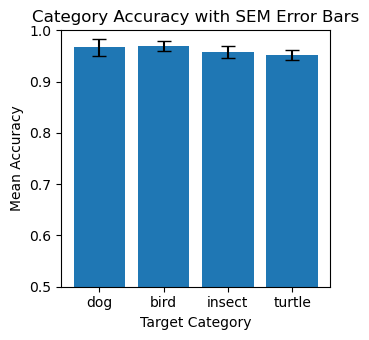


 === TP ===
# of dog stimuli: 11
# of bird stimuli: 20
# of insect stimuli: 22
# of turtle stimuli: 25


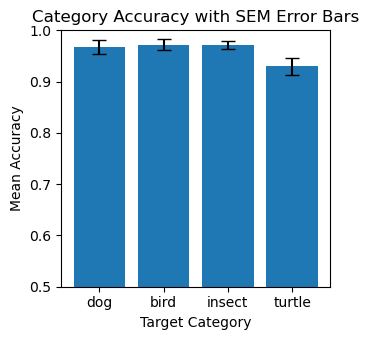


 === TA ===
# of dog stimuli: 25
# of bird stimuli: 25
# of insect stimuli: 25
# of turtle stimuli: 25


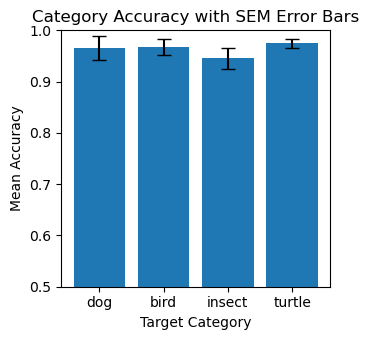

In [6]:
# category-wise accuracy

TAP_list = ['Combined', 'TP', 'TA']

for i, TAP in enumerate(TAP_list):
    print(f'\n === {TAP} ===')
    if TAP == 'Combined':
        fdictlist_TAP = fdictlist  # [fd for fd in fdictlist if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
    elif TAP == 'TP':
        fdictlist_TAP = fdictlist_TP  # [fd for fd in fdictlist_TP if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP
    elif TAP == 'TA':
        fdictlist_TAP = fdictlist_TA  # [fd for fd in fdictlist_TA if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TA
    else:
        raise NotImplementedError(f"Invalid TAP: {TAP}")
    
    # Loop over each target category to compute means and SEMs
    category_means = []
    category_sems = []
    for target in TARGET_CATEGORIES:
        stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TAP))
        print(f'# of {target} stimuli:', len(stimuli_info_TAP_target))
         
        stim_accs = []
        for info in stimuli_info_TAP_target:
            imgid = info['display_idx']
            trials = list(filter(lambda x: x['IMAGE_ID'] == imgid, fdictlist_TAP))
            if not trials:
                continue
            accs = [trial['ACC'] for trial in trials]
            stim_accs.append(np.mean(accs))
        
        category_means.append(np.mean(stim_accs))
        category_sems.append(sem(stim_accs))
    
    # Create numerical x-positions for the target categories
    x_positions = np.arange(len(TARGET_CATEGORIES))

    # Create a bar graph with error bars representing SEM
    plt.figure(figsize=(3.5, 3.5))
    plt.bar(x_positions, category_means, yerr=category_sems, align='center', capsize=5)
    plt.xticks(x_positions, TARGET_CATEGORIES)
    plt.ylim(0.5, 1)
    plt.xlabel('Target Category')
    plt.ylabel('Mean Accuracy')
    plt.title('Category Accuracy with SEM Error Bars')
    plt.tight_layout()
    plt.show()


# cumulative fixation plot
- grid search over softmax temp parameters, and got best param for each model 'priority_raw' --> 'priority'
- human's cfp is based on non-center fixations

In [7]:
# human cumulative fixation probability
import random
def get_CDF(num_steps, max_step):
    cdf_mean = np.zeros(max_step)
    cdf_sem = np.zeros(max_step)
    
    if isinstance(num_steps, np.ndarray):
        total = float(len(num_steps))
    else:
        total = 1.0
        
    for i in range(1, max_step + 1):
        cdf_mean[i - 1] = np.sum(num_steps <= i) / total
        cdf_sem[i - 1] = np.std(num_steps <= i) / np.sqrt(total-1)
    return cdf_mean, cdf_sem

def get_model_num_steps_to_target(problist, target_idx, rseed=0, n_fixation_sample=5):
        random.seed(rseed)
        sampled_probs = random.choices(problist,weights=problist, k=n_fixation_sample)
        sampled_indices = [problist.index(value) for value in sampled_probs]

        for numstep, idx in enumerate(sampled_indices):
            if idx == target_idx:
                break
        return numstep
        

# get num steps to get to the target, if staying at the center just 1,
N_MAXFIX =5
TEMP_PARAMS = [1/100, 1/10, 1/5, 1/2, 1, 2, 5, 10, 100, 1000]

meanslist_subj=[]
semslist_subj=[]

meanslist_our=[]
semslist_our=[]

meanslist_cnn=[]
semslist_cnn=[]

numsteplist_subj_all = []
for subj in subject_ids:
    fdictlist_TAP_subj_correct = list(filter(lambda x: x['SUBJECT_ID']==subj and  x['ACC'],fdictlist_TP))

    numsteplist_subj = []
    numsteplist_our = []
    numsteplist_cnn = []
    
    for fidx, fd in enumerate(fdictlist_TAP_subj_correct):
        imgid = fd['IMAGE_ID']
        trial = list(filter(lambda x: x['display_idx']==imgid, stimuli_info_TP))[0]
        
        # continue if it's all center fixations
        if all(value == -1 for value in fd['ROI_LABELS']):
            continue #numstep= 1 # or len(fd['ROI_LABELS'])#continue 

        # human get num step to first target visited based on ROI labels (ignored -1)
        roilistwocenter = [roi for roi in fd['ROI_LABELS'] if roi != -1]
        #roilistwocenter = [roi for roi in fd['ROI_LABELS']]
        # for numstep, value in enumerate(fd['ROI_LABELS']):
        for numstep, value in enumerate(roilistwocenter):
            if value == trial['target_idx_in_objlist']:
                break  # Stop when the first target fixated
        
        numsteplist_subj.append(numstep)
        
        numsteplist_our_temp = []
        numsteplist_cnn_temp = []
        # model get num step to first targe visited based on bbox
        for temp in TEMP_PARAMS:
            our_priority = stable_softmax(trial['our_priority_raw'], temp=temp)
            cnn_priority = stable_softmax(trial['cnn_priority_raw'], temp=temp)
            numstep = get_model_num_steps_to_target(list(our_priority), trial['target_idx_in_objlist'], rseed=fidx, n_fixation_sample=N_MAXFIX)
            numsteplist_our_temp.append(numstep)
            numstep = get_model_num_steps_to_target(list(cnn_priority), trial['target_idx_in_objlist'], rseed=fidx, n_fixation_sample=N_MAXFIX)
            numsteplist_cnn_temp.append(numstep)

        numsteplist_our.append(numsteplist_our_temp)
        numsteplist_cnn.append(numsteplist_cnn_temp)

    numsteplist_subj_all.extend(numsteplist_subj)
    
    # human cdf
    means, sems = get_CDF(np.array(numsteplist_subj), 5)
    meanslist_subj.append(means)
    semslist_subj.append(sems)

    # model cdfs
    meanslist_our_temp = []
    semslist_our_temp = []
    meanslist_cnn_temp = []
    semslist_cnn_temp = []

    for i in range(len(TEMP_PARAMS)):
        means, sems = get_CDF(np.array(numsteplist_our)[:,i], N_MAXFIX)
        meanslist_our_temp.append(means)
        semslist_our_temp.append(sems)    

        means, sems = get_CDF(np.array(numsteplist_cnn)[:,i],  N_MAXFIX)
        meanslist_cnn_temp.append(means)
        semslist_cnn_temp.append(sems)    

    meanslist_our.append(meanslist_our_temp)
    semslist_our.append(semslist_our_temp)
    meanslist_cnn.append(meanslist_cnn_temp)
    semslist_cnn.append(semslist_cnn_temp)

meanslist_subj = np.array(meanslist_subj)
semslist_subj = np.array(semslist_subj)
meanslist_our = np.array(meanslist_our)
semslist_our = np.array(semslist_our)
meanslist_cnn = np.array(meanslist_cnn)
semslist_cnn = np.array(semslist_cnn)
# meanslist_subj.shape, meanslist_our.shape,meanslist_cnn.shape
# ((55, 5), (55, 9, 5), (55, 9, 5))



print("# of steps to target; avg, max, min")
print(np.mean(numsteplist_subj_all), np.max(numsteplist_subj_all), np.min(numsteplist_subj_all))

print("human CDF", np.round(meanslist_subj.mean(axis=0),3))

print("\n====our model best fit @temp:")
l2list=[]
for i in range(len(TEMP_PARAMS)):
    l2 = (meanslist_subj - meanslist_our[:,i])**2
    l2list.append(l2.sum())
our_besttempidx = np.argmin(l2list)
our_besttemp = TEMP_PARAMS[our_besttempidx]
print(our_besttemp)
print("mean squared losses:", np.round(l2list,3))
print(meanslist_our[:,our_besttempidx].mean(axis=0).round(3))

print("\n=====cnn model best fit @temp:")
l2list=[]
for i in range(len(TEMP_PARAMS)):
    l2 = (meanslist_subj - meanslist_cnn[:,i])**2
    l2list.append(l2.sum())
cnn_besttempidx = np.argmin(l2list)
cnn_besttemp = TEMP_PARAMS[cnn_besttempidx]
print(cnn_besttemp)
print("mean squared losses:", np.round(l2list,3))
print(meanslist_cnn[:,cnn_besttempidx].mean(axis=0).round(3))

meanslist_our = meanslist_our[:,our_besttempidx]
semslist_our = semslist_our[:,our_besttempidx]
meanslist_cnn = meanslist_cnn[:,cnn_besttempidx]
semslist_cnn = semslist_cnn[:,cnn_besttempidx]

grand_mean = np.mean(np.array(meanslist_subj), axis=0)
grand_sem = np.std(np.array(meanslist_subj), axis=0)/np.sqrt(len(meanslist_subj)-1)

grand_mean_our = np.mean(np.array(meanslist_our), axis=0)
grand_sem_our = np.std(np.array(meanslist_our), axis=0)/np.sqrt(len(meanslist_our)-1)

grand_mean_cnn = np.mean(np.array(meanslist_cnn), axis=0)
grand_sem_cnn = np.std(np.array(meanslist_cnn), axis=0)/np.sqrt(len(meanslist_cnn)-1)

# get priority prob using the best temp param
for info in stimuli_info:
    info['our_priority'] = stable_softmax(info['our_priority_raw'],  temp=our_besttemp)
    info['cnn_priority'] = stable_softmax(info['cnn_priority_raw'],  temp=cnn_besttemp)



# of steps to target; avg, max, min
0.6962379257752923 6 0
human CDF [0.864 0.967 0.991 0.998 1.   ]

====our model best fit @temp:
0.2
mean squared losses: [ 1.475  1.219  0.637  3.254 11.066 18.784 22.909 23.739 25.024 25.024]
[0.889 0.955 0.983 1.    1.   ]

=====cnn model best fit @temp:
2
mean squared losses: [ 1.66   1.66   1.66   1.656  1.312  0.738  3.247  9.609 23.444 25.024]
[0.895 0.949 0.961 1.    1.   ]


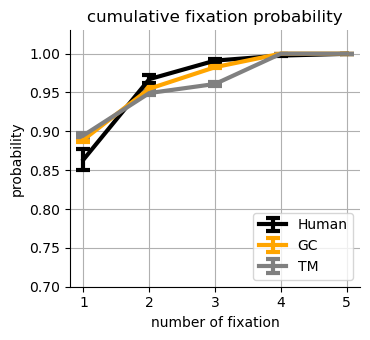

In [8]:
SAVE=False
plt.rcParams["figure.figsize"]=3.8,3.5

fig, ax = plt.subplots()

# X-axis values (e.g., time points)
x_values = [1, 2, 3, 4, 5]

# Create a line plot with error bars for means and SEMs
ax.errorbar(x_values, grand_mean, yerr=grand_sem, label='Human', color='black', capsize=5, elinewidth=3, capthick=3, linewidth=3)
ax.errorbar(x_values, grand_mean_our, yerr=grand_sem_our, label='GC', color='orange', capsize=5, elinewidth=3, capthick=3, linewidth=3)
ax.errorbar(x_values, grand_mean_cnn, yerr=grand_sem_cnn, label='TM', color='gray', capsize=5, elinewidth=3, capthick=3, linewidth=3)

# Customize the plot (add labels, title, legend, etc.)
ax.set_ylim(0.7,1.03)
ax.set_xlabel('number of fixation')
ax.set_ylabel('probability')
ax.set_title('cumulative fixation probability')

plt.legend(loc='lower right')  # Add a legend

# Show the plot
ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

if SAVE:
    plt.savefig(f'../figures/savefig/CFP_{IMAGE_TYPE}.png', dpi=300,  bbox_inches='tight')
plt.show()

# priority maps
- human probs are computed on item areas (excluding center areas)

In [10]:

# Set up save directory
SAVE_DIR = f'../results/correlation_w_human_priority_template_{IMAGE_TYPE}'
os.makedirs(SAVE_DIR, exist_ok=True)

# Process data and save results (pickled DataFrames)
for NFIX in ['all', 1, 2, 3]:
    for TAP in ['TP', 'TA']:
        # Filter fdictlist and stimuli_info by condition
        if TAP == 'TP':
            fdictlist_TAP = fdictlist_TP
            stimuli_info_TAP = stimuli_info_TP
        else:  # TAP == 'TA'
            fdictlist_TAP = fdictlist_TA
            stimuli_info_TAP = stimuli_info_TA

        print(f'Condition: {TAP} -- # of stimuli: {len(stimuli_info_TAP)}')

        for correlation_type in ['pearson', 'spearman']:
            imgid_list, human_probs, our_probs, cnn_probs = [], [], [], []
            corr_cnn_list, corr_pvalue_cnn_list = [], []
            corr_our_list, corr_pvalue_our_list = [], []

            for trial in stimuli_info_TAP:
                imgid = trial['display_idx']
                imgid_list.append(imgid)
                # Get all correct trials for the current image id
                trial_fdicts = [fd for fd in fdictlist_TAP if fd['IMAGE_ID'] == imgid and fd['ACC']]
                
                # Get ROI counts
                labels = []
                for fd in trial_fdicts:
                    not_center_area = np.where(np.array(fd['ROI_LABELS']) != -1)[0]
                    if NFIX == 'all':
                        labels.extend(fd['ROI_LABELS'])
                        not_center_area
                    else:
                        if len(not_center_area) >= NFIX:
                            labels.append(not_center_area[NFIX - 1])
                
                # Frequency counts for ROI labels 0, 1, 2, 3
                f_obs = np.array([labels.count(ri) for ri in [0, 1, 2, 3]])
                prob_obs = np.round(f_obs / (f_obs.sum() + 1e-5), 3)
                human_probs.append(prob_obs.tolist())
                cnn_probs.append(trial['cnn_priority'])
                our_probs.append(trial['our_priority'])

                # Compute correlation between the observed probability distribution and the model priorities
                if correlation_type == 'spearman':
                    cnn_corr, cnn_p = spearmanr(prob_obs, trial['cnn_priority'])
                    our_corr, our_p = spearmanr(prob_obs, trial['our_priority'])
                else:  # pearson
                    cnn_corr, cnn_p = pearsonr(prob_obs, trial['cnn_priority'])
                    our_corr, our_p = pearsonr(prob_obs, trial['our_priority'])

                corr_cnn_list.append(cnn_corr)
                corr_pvalue_cnn_list.append(cnn_p)
                corr_our_list.append(our_corr)
                corr_pvalue_our_list.append(our_p)

            # Create DataFrame with all results
            df = pd.DataFrame({
                'imgid': imgid_list,
                'human_probs': human_probs,
                'our_probs': our_probs,
                'cnn_probs': cnn_probs,
                'our_corr': corr_our_list,
                'our_corr_pvalue': corr_pvalue_our_list,
                'cnn_corr': corr_cnn_list,
                'cnn_corr_pvalue': corr_pvalue_cnn_list
            })

            path_df = f'{SAVE_DIR}/{TAP}_priority_prob_corr_{correlation_type}_f{NFIX}.pkl'
            if os.path.exists(path_df):
                print(f'File exists: {TAP}_priority_prob_corr_{correlation_type}_f{NFIX}')
            else:
                df.to_pickle(path_df)
                print(f'Saved to disk: {TAP}_priority_prob_corr_{correlation_type}_f{NFIX}')



Condition: TP -- # of stimuli: 78
Saved to disk: TP_priority_prob_corr_pearson_fall
Saved to disk: TP_priority_prob_corr_spearman_fall
Condition: TA -- # of stimuli: 100
Saved to disk: TA_priority_prob_corr_pearson_fall
Saved to disk: TA_priority_prob_corr_spearman_fall
Condition: TP -- # of stimuli: 78
Saved to disk: TP_priority_prob_corr_pearson_f1
Saved to disk: TP_priority_prob_corr_spearman_f1
Condition: TA -- # of stimuli: 100
Saved to disk: TA_priority_prob_corr_pearson_f1
Saved to disk: TA_priority_prob_corr_spearman_f1
Condition: TP -- # of stimuli: 78
Saved to disk: TP_priority_prob_corr_pearson_f2
Saved to disk: TP_priority_prob_corr_spearman_f2
Condition: TA -- # of stimuli: 100
Saved to disk: TA_priority_prob_corr_pearson_f2
Saved to disk: TA_priority_prob_corr_spearman_f2
Condition: TP -- # of stimuli: 78
Saved to disk: TP_priority_prob_corr_pearson_f3
Saved to disk: TP_priority_prob_corr_spearman_f3
Condition: TA -- # of stimuli: 100
Saved to disk: TA_priority_prob_corr_

ANALYSIS for Combined, pearson, target=all
Number of trials: 178
Our: 0.625 ± 0.038
CNN: 0.468 ± 0.047
Paired t-test: t = 3.352, p = 0.001

ANALYSIS for TP, pearson, target=all
Number of trials: 78
Our: 0.930 ± 0.011
CNN: 0.924 ± 0.010
Paired t-test: t = 0.385, p = 0.701

ANALYSIS for TA, pearson, target=all
Number of trials: 100
Our: 0.387 ± 0.056
CNN: 0.112 ± 0.063
Paired t-test: t = 3.404, p = 0.001



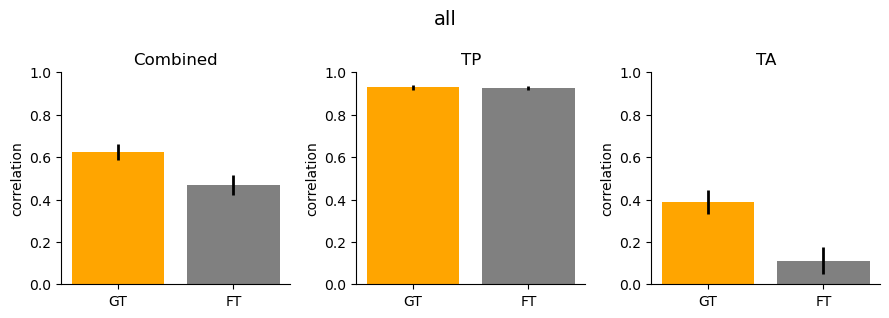

Statistical summary saved to ../results/correlation_w_human_priority_template_clean/statistical_summary_fall_all_clean.csv


In [8]:
SAVE_DIR = f'../results/correlation_w_human_priority_template_{IMAGE_TYPE}'

# --------------------------
# Statistical Analysis & Plotting with Combined Results
# --------------------------
SAVE_FIG = True # Set True to save the combined figure
target = 'all'  # e.g., set to 'turtle' to filter by target, or leave as 'all' for all trials
NFIX = 'all'     # 'all'

# Prepare a list to hold summary stats for CSV output
stat_results = []

# Create a figure with 6 subplots in one row (TP, TA, and Combined for each correlation type)
fig, axs = plt.subplots(1, 3, figsize=(9, 3.2)) #18 if spearman included
subplot_idx = 0

for correlation_type in ['pearson']: #'spearman'
    # Load precomputed data for TP and TA
    dfTP = pd.read_pickle(f'{SAVE_DIR}/TP_priority_prob_corr_{correlation_type}_f{NFIX}.pkl')
    dfTA = pd.read_pickle(f'{SAVE_DIR}/TA_priority_prob_corr_{correlation_type}_f{NFIX}.pkl')

    # Combined analysis: merge TA and TP datasets
    combined_data = pd.concat([dfTP, dfTA])
    if target != 'all':
        combined_data = combined_data[combined_data['imgid'].isin(d_target2imgid[target])]
    
    n_trials = len(combined_data)
    mean_our = combined_data['our_corr'].mean()
    sem_our = combined_data['our_corr'].sem()
    mean_cnn = combined_data['cnn_corr'].mean()
    sem_cnn = combined_data['cnn_corr'].sem()
    
    t_stat, p_val = stats.ttest_rel(combined_data['our_corr'], combined_data['cnn_corr'])
    
    print(f'ANALYSIS for Combined, {correlation_type}, target={target}')
    print(f'Number of trials: {n_trials}')
    print(f"Our: {mean_our:.3f} ± {sem_our:.3f}")
    print(f"CNN: {mean_cnn:.3f} ± {sem_cnn:.3f}")
    print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3f}\n")
    
    stat_results.append({
        'correlation_type': correlation_type,
        'TAP': 'Combined',
        'n_trials': n_trials,
        'mean_our': mean_our,
        'sem_our': sem_our,
        'mean_cnn': mean_cnn,
        'sem_cnn': sem_cnn,
        't_stat': t_stat,
        'p_val': p_val
    })
    
    ax = axs[subplot_idx]
    categories = ['GT', 'FT']
    x = np.arange(len(categories))
    means = [mean_our, mean_cnn]
    sems = [sem_our, sem_cnn]
    ax.bar(x, means, yerr=sems, capsize=0, error_kw={'elinewidth': 2}, color=["orange", "gray"])
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel("correlation")
    ax.set_title(f'Combined') #- {correlation_type}
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0, 1)
    subplot_idx += 1
    
    # Process individual datasets: TP and TA
    for TAP, data in zip(['TP', 'TA'], [dfTP.copy(), dfTA.copy()]):
        # Optionally filter by target (if target_filter is set)
        if target != 'all':
            data = data[data['imgid'].isin(d_target2imgid[target])]
        
        n_trials = len(data)
        mean_our = data['our_corr'].mean()
        sem_our = data['our_corr'].sem()
        mean_cnn = data['cnn_corr'].mean()
        sem_cnn = data['cnn_corr'].sem()
        
        # Paired t-test between "our" and "cnn" correlations
        t_stat, p_val = stats.ttest_rel(data['our_corr'], data['cnn_corr'])
        
        print(f'ANALYSIS for {TAP}, {correlation_type}, target={target}')
        print(f'Number of trials: {n_trials}')
        print(f"Our: {mean_our:.3f} ± {sem_our:.3f}")
        print(f"CNN: {mean_cnn:.3f} ± {sem_cnn:.3f}")
        print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3f}\n")
        
        # Append results for CSV
        stat_results.append({
            'correlation_type': correlation_type,
            'TAP': TAP,
            'n_trials': n_trials,
            'mean_our': mean_our,
            'sem_our': sem_our,
            'mean_cnn': mean_cnn,
            'sem_cnn': sem_cnn,
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Plot bar chart on its respective subplot
        ax = axs[subplot_idx]
        categories = ['GT', 'FT']
        x = np.arange(len(categories))
        means = [mean_our, mean_cnn]
        sems = [sem_our, sem_cnn]
        ax.bar(x, means, yerr=sems, capsize=0, error_kw={'elinewidth': 2}, color=["orange", "gray"])
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.set_ylabel("correlation")
        ax.set_title(f'{TAP}') #- {correlation_type}
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylim(0, 1)
        
        subplot_idx += 1
        
plt.suptitle(target, fontsize=14)
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f'../figures/savefig/priority_corr_f{NFIX}_{target}_{IMAGE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the statistical summary as a CSV file
df_stat = pd.DataFrame(stat_results)
csv_path = f'{SAVE_DIR}/statistical_summary_f{NFIX}_{target}_{IMAGE_TYPE}.csv'
df_stat.to_csv(csv_path, index=False)
print(f'Statistical summary saved to {csv_path}')


In [66]:
info

{'display_idx': 76,
 'display_filename': 'TP_dog_d76',
 'condition': 'TP',
 'target_label': 'dog',
 'target_index': 0,
 'clean_objlist': ['../data/imagenet_val_segmented_resized/dog/n02106382_ILSVRC2012_val_00033579.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n04120489_ILSVRC2012_val_00005869.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n04579432_ILSVRC2012_val_00005350.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n04065272_ILSVRC2012_val_00000014.JPEG'],
 'foveated_objlist': ['../data/imagenet_val_segmented_resized_foveated/dog/TP_dog_d76-b0-n02106382_ILSVRC2012_val_00033579.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d76-b1-n04120489_ILSVRC2012_val_00005869.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d76-b2-n04579432_ILSVRC2012_val_00005350.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TP_dog_d76-b3-n04065272_ILSVRC2012_val_00000014.JPEG'],
 'target_idx_in_ob

ANALYSIS for TP, target=all
# of stimuli: 78
Human: 0.463 ± 0.021
Our: 0.680 ± 0.015, correlation=0.304, p-value=0.007
CNN: 0.718 ± 0.019, correlation=-0.275, p-value=0.015

ANALYSIS for TP, target=dog
# of stimuli: 11
Human: 0.506 ± 0.049
Our: 0.706 ± 0.051, correlation=0.063, p-value=0.854
CNN: 0.541 ± 0.040, correlation=0.228, p-value=0.500

ANALYSIS for TP, target=bird
# of stimuli: 20
Human: 0.486 ± 0.035
Our: 0.723 ± 0.026, correlation=0.169, p-value=0.475
CNN: 0.671 ± 0.034, correlation=-0.496, p-value=0.026

ANALYSIS for TP, target=insect
# of stimuli: 22
Human: 0.520 ± 0.038
Our: 0.668 ± 0.030, correlation=0.385, p-value=0.077
CNN: 0.704 ± 0.028, correlation=0.184, p-value=0.411

ANALYSIS for TP, target=turtle
# of stimuli: 25
Human: 0.376 ± 0.040
Our: 0.643 ± 0.024, correlation=0.359, p-value=0.078
CNN: 0.847 ± 0.025, correlation=-0.281, p-value=0.173



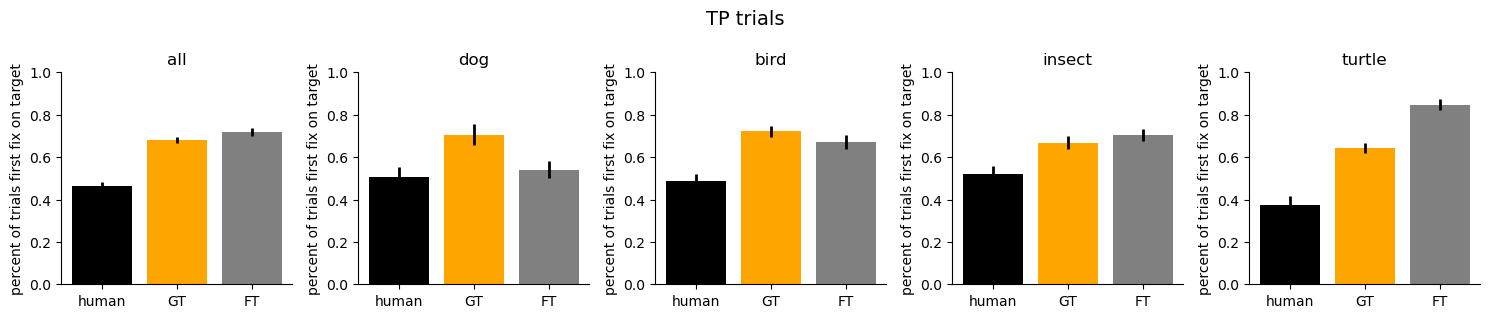

In [73]:
# first fixation on target probability

SAVE_DIR = f'../results/first_fix_on_target_{IMAGE_TYPE}'
os.makedirs(SAVE_DIR, exist_ok=True)
TAP = 'TP'


fdictlist_TAP = [fd for fd in fdictlist_TP if fd['ACC']]
stimuli_info_TAP = stimuli_info_TP


fig, axs = plt.subplots(1, 5, figsize=(15, 3.2)) #3* cols if spearman included
subplot_idx = 0

for subplot_idx, target in enumerate(['all', 'dog', 'bird', 'insect', 'turtle']):
    print(f'ANALYSIS for {TAP}, target={target}')

    if target != 'all':
        stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TAP))  
    else:
        stimuli_info_TAP_target = stimuli_info_TAP 
    print('# of stimuli:', len(stimuli_info_TAP_target))



    avg_measures = []
    our_scores = []
    cnn_scores = []

    # Loop over each stimulus
    for info in stimuli_info_TAP_target:
        imgid = info['display_idx']
        # Filter trials corresponding to this image
        trials = list(filter(lambda x: x['IMAGE_ID'] == imgid, fdictlist_TAP))
        if not trials:
            continue
        
        n_trial_first_fix_on_target_human =0 
        for trial in trials:
            target_idx = int(info['target_idx_in_objlist'])
            first_fix = next((v for v in trial['ROI_LABELS'] if v != -1), None)
            if first_fix is None:
                continue
            if first_fix == target_idx:
                n_trial_first_fix_on_target_human += 1

                
        percent_trial_first_fix_after_target_human = n_trial_first_fix_on_target_human / len(trials)
        avg_measures.append(percent_trial_first_fix_after_target_human)
        # os_target = info['our_priority_raw'][info['target_idx_in_objlist']]
        # cs_target = info['cnn_priority_raw'][info['target_idx_in_objlist']]
        # our_scores.append(-GC_BUDGET * os_target)
        # cnn_scores.append(-cs_target)
        os_target = info['our_priority'][info['target_idx_in_objlist']]
        cs_target = info['cnn_priority'][info['target_idx_in_objlist']]
        our_scores.append(os_target)
        cnn_scores.append(cs_target)    

    combined_data = pd.DataFrame({
        'imgid': [info['display_idx'] for info in stimuli_info_TAP_target],
        'avg_measures': avg_measures,
        'our_scores': our_scores,
        'cnn_scores': cnn_scores
    })

    mean_human = np.mean(avg_measures)
    sem_human = sem(avg_measures)
    mean_our = np.mean(our_scores)
    sem_our = sem(our_scores)
    mean_cnn = np.mean(cnn_scores)
    sem_cnn = sem(cnn_scores)

    # correlation
    corr_our, pvalue_our = pearsonr(combined_data['avg_measures'], combined_data['our_scores'])
    corr_cnn, pvalue_cnn = pearsonr(combined_data['avg_measures'], combined_data['cnn_scores'])
    print(f"Human: {mean_human:.3f} ± {sem_human:.3f}")
    print(f"Our: {mean_our:.3f} ± {sem_our:.3f}, correlation={corr_our:.3f}, p-value={pvalue_our:.3f}")
    print(f"CNN: {mean_cnn:.3f} ± {sem_cnn:.3f}, correlation={corr_cnn:.3f}, p-value={pvalue_cnn:.3f}\n")

    ax = axs[subplot_idx]
    categories = ['human', 'GT', 'FT']
    x = np.arange(len(categories))
    means = [mean_human, mean_our, mean_cnn]
    sems = [sem_human, sem_our, sem_cnn]
    ax.bar(x, means, yerr=sems, capsize=0, error_kw={'elinewidth': 2}, color=["black", "orange", "gray"])
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel("percent of trials first fix on target")
    ax.set_title(target) #- {correlation_type}
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0, 1)

        
plt.suptitle('TP trials', fontsize=14)
plt.tight_layout()
# if SAVE_FIG:
#     fig.savefig(f'../figures/savefig/priority_corr_f{NFIX}_{target}_{IMAGE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()



ANALYSIS for TP, target=dog
# of stimuli: 11
ANALYSIS for TP, target=bird
# of stimuli: 20
ANALYSIS for TP, target=insect
# of stimuli: 22
ANALYSIS for TP, target=turtle
# of stimuli: 25
[[0.505899162233394, 0.4859263660251451, 0.5195404470154746, 0.37564380940825465], [0.7062168076234792, 0.7228751024515072, 0.6682912166082263, 0.6431823221755735], [0.541357, 0.670536, 0.70416856, 0.84689856]]
0.47175244617056705 0.6851413622146965 0.69074


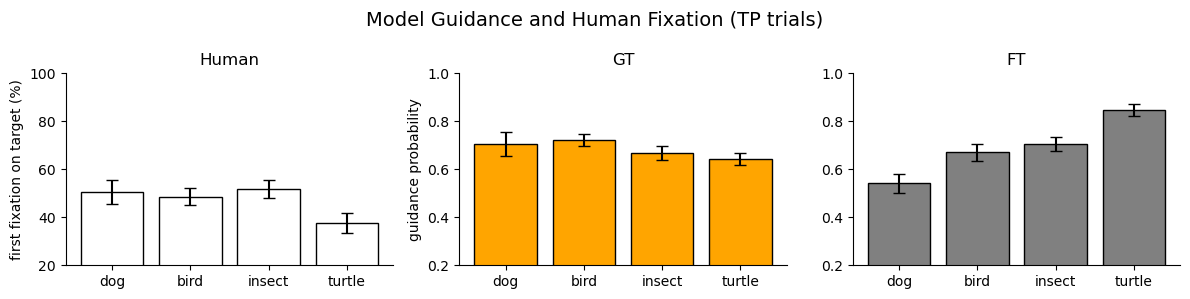

In [91]:
SAVE_FIG=True

# Define categories and storage
categories = ['dog', 'bird', 'insect', 'turtle']
human_means, human_sems = [], []
our_means, our_sems = [], []
cnn_means, cnn_sems = [], []

# Loop over each category and collect means/SEMs for each method
for target in categories:
    print(f'ANALYSIS for TP, target={target}')
    
    stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TP))  
    print('# of stimuli:', len(stimuli_info_TAP_target))

    avg_measures = []
    our_scores = []
    cnn_scores = []

    for info in stimuli_info_TAP_target:
        imgid = info['display_idx']
        trials = list(filter(lambda x: x['IMAGE_ID'] == imgid, fdictlist_TAP))
        if not trials:
            continue

        n_trial_only_central = 0
        n_trial_first_fix_on_target_human = 0
        correct_trials = [fd for fd in trials if fd['ACC']]
        n_trials_correct = len(correct_trials)
        
        for trial in trials:
            

            target_idx = int(info['target_idx_in_objlist'])
            first_fix = next((v for v in trial['ROI_LABELS'] if v != -1), None)
            if first_fix is None:
                # Only central fixation found in this trial.
                n_trial_only_central += 1
                continue
            if first_fix == target_idx:
                n_trial_first_fix_on_target_human += 1

        # denominator = n_trials_correct - n_trial_only_central
        # if denominator > 0:
        #     percent_trial_first_fix_after_target_human  = n_trial_first_fix_on_target_human / denominator
        # else:
        #     percent_trial_first_fix_after_target_human  = np.nan

        percent_trial_first_fix_after_target_human  = n_trial_first_fix_on_target_human / len(trials)

        avg_measures.append(percent_trial_first_fix_after_target_human)
        os_target = info['our_priority'][info['target_idx_in_objlist']]
        cs_target = info['cnn_priority'][info['target_idx_in_objlist']]
        our_scores.append(os_target)
        cnn_scores.append(cs_target)    

    # Store mean and SEM for each model
    human_means.append(np.mean(avg_measures))
    human_sems.append(sem(avg_measures))
    our_means.append(np.mean(our_scores))
    our_sems.append(sem(our_scores))
    cnn_means.append(np.mean(cnn_scores))
    cnn_sems.append(sem(cnn_scores))

# ==== PLOTTING ====
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

models = ['Human', 'GT', 'FT']
model_means = [human_means, our_means, cnn_means]
model_sems = [human_sems, our_sems, cnn_sems]
colors = ['white', 'orange', 'gray']
ylabels = ['first fixation on target (%)', 'guidance probability', 'guidance probability']

print([human_means, our_means, cnn_means])
print(np.mean(human_means), np.mean(our_means), np.mean(cnn_means))

for i in range(3):
    ax = axs[i]

    if i == 0:
        # Human: convert to percent
        means = [val * 100 for val in model_means[i]]
        sems = [val * 100 for val in model_sems[i]]
        ax.set_ylim(20, 100)
    else:
        # GT/FT: keep raw probability scale
        means = model_means[i]
        sems = model_sems[i]
        ax.set_ylim(0.2, 1.0)

    ax.bar(categories, means, yerr=sems, capsize=4, color=colors[i], edgecolor='black')
    ax.set_title(models[i])
    ax.set_ylabel(ylabels[i] if i == 0 or i == 1 else "")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Model Guidance and Human Fixation (TP trials)', fontsize=14)
plt.tight_layout()

if SAVE_FIG:
    fig.savefig(f'../figures/savefig/{TAP}_first_fix_on_target_{IMAGE_TYPE}.png', dpi=300, bbox_inches='tight')

plt.show()

# epoch time analysis (TP)

In [64]:
# epoch analysis on TP data
subject_results = []  # Each row: [Subject, Button Press Acc, First Fix Acc, Central-only Trials, Total Correct Trials]


for subj in subject_ids:
    subj_trials = [fd for fd in fdictlist_TP if fd['SUBJECT_ID'] == subj]
    n_trials = len(subj_trials)
    correct_trials = [fd for fd in subj_trials if fd['ACC']]
    n_trials_correct = len(correct_trials)
    if n_trials == 0:
        continue

    subj_n_trial_fix_after_target = 0
    subj_n_trial_firstfix_correct = 0
    subj_n_trial_only_central = 0

    for fd in correct_trials:
        imgid = fd['IMAGE_ID']
        # Get the trial info matching this image id
        trial_info_list = [trial for trial in stimuli_info_TP if trial['display_idx'] == imgid]
        if not trial_info_list:
            print(f"Warning: No trial info found for IMAGE_ID {imgid}")
            continue
        trial_info = trial_info_list[0]
        # IMPORTANT: Verify if trial_info is a dict or list.
        # The original code uses trial_info[0]['target_idx_in_objlist'], adjust if needed.
        target_idx = trial_info['target_idx_in_objlist']  # Adjust if needed

        # Retrieve first non-central fixation (-1 indicates central)
        first_fix = next((v for v in fd['ROI_LABELS'] if v != -1), None)
        if first_fix is None:
            # Only central fixation found in this trial.
            subj_n_trial_only_central += 1
            continue
        if first_fix == target_idx:
            subj_n_trial_firstfix_correct += 1

        # check if target_idx is in fd['ROI_LABELS']
        if (target_idx in fd['ROI_LABELS']):
            index = fd['ROI_LABELS'].index(target_idx)
            if index < len(fd['ROI_LABELS']) - 1: # Check if there is a fixation after the target
                subj_n_trial_fix_after_target+= 1
            else:
                # No fixation after target
                continue


    # Calculate first fixation accuracy (avoid division by zero)
    denominator = n_trials_correct - subj_n_trial_only_central
    if denominator > 0:
        subj_first_fix_acc = subj_n_trial_firstfix_correct / denominator
    else:
        subj_first_fix_acc = np.nan
    
    percent_trial_fix_after_target = subj_n_trial_fix_after_target/len(correct_trials)

    subject_results.append([
        subj, 
        n_trials_correct,
        subj_n_trial_fix_after_target,
        round(percent_trial_fix_after_target, 3), 
        subj_n_trial_firstfix_correct,
        subj_first_fix_acc,
    ])

# Create DataFrame for subject-level results
df_subject = pd.DataFrame(
    subject_results, 
    columns=["Subject", "n_correct_trials (denominator)",  "n_trial_fix_after_target", "percent_trial_fix_after_target", "n_trial_first_fix_on_target", "percent_trial_first_fix_on_target"]
)

print(df_subject.to_string(index=False))

print('\n=== Overall Summary ===')  
overall_summary = {
    "Metric": ["Total Correct Trials", 
               "Total Trials with Fixation after Target", 
               "Percent Trials with Fixation after Target",
               "Total Trials with First Fixation on Target",
               "Percent Trials with First Fixation on Target"],
    "Value": [
        df_subject["n_correct_trials (denominator)"].mean(),
        df_subject["n_trial_fix_after_target"].mean(),
        df_subject["percent_trial_fix_after_target"].mean(),
        df_subject["n_trial_first_fix_on_target"].mean(),
        df_subject["percent_trial_first_fix_on_target"].mean()
    ]
}
df_overall = pd.DataFrame(overall_summary)
print(df_overall.to_string(index=False))

Subject  n_correct_trials (denominator)  n_trial_fix_after_target  percent_trial_fix_after_target  n_trial_first_fix_on_target  percent_trial_first_fix_on_target
  ST001                              78                        64                           0.821                           29                           0.371795
  ST002                              76                        61                           0.803                           33                           0.434211
  ST003                              70                        48                           0.686                           32                           0.470588
  ST004                              65                        21                           0.323                           22                           0.423077
  ST005                              76                        42                           0.553                           36                           0.521739
  ST006                     

# of stimuli: 22


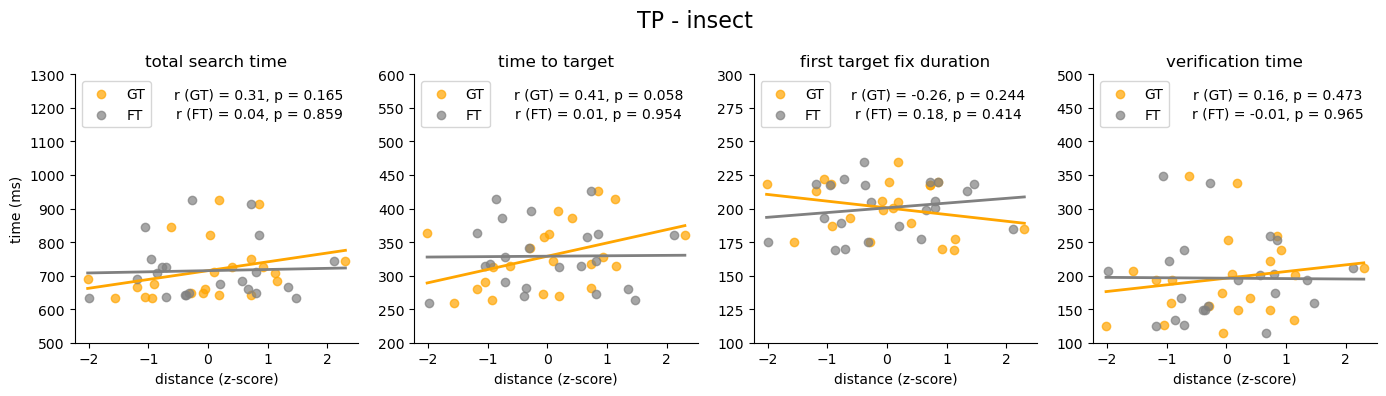

In [35]:
import matplotlib.ticker as ticker

SAVE_FIG = True
print_correlation = True
TAP_list = ['TP']
GUIDANCE_MEASURES = ['total_search_time', 'time_to_target', 'first_target_fix_duration', 'verification_time']
target = 'insect'#'all'

def remove_outliers_pair(x, y, threshold=3):
    """
    Remove paired outliers based on a z-score threshold.
    Only keep pairs where both x and y are within the threshold.
    """
    x = np.array(x)
    y = np.array(y)
    z_x = np.abs((x - np.mean(x)) / np.std(x))
    z_y = np.abs((y - np.mean(y)) / np.std(y))
    mask = (z_x < threshold) & (z_y < threshold)
    return x[mask], y[mask]

# Create a subplot grid: rows = TAP groups, cols = guidance measures
fig, axs = plt.subplots(nrows=len(TAP_list), ncols=len(GUIDANCE_MEASURES),
                        figsize=(3.5 * len(GUIDANCE_MEASURES), 3.5 * len(TAP_list)+0.5),
                        squeeze=False)

for i, TAP in enumerate(TAP_list):
    if TAP == 'Combined':
        fdictlist_TAP = [fd for fd in fdictlist if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
    elif TAP == 'TP':
        fdictlist_TAP = [fd for fd in fdictlist_TP if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP
    elif TAP == 'TA':
        fdictlist_TAP = [fd for fd in fdictlist_TA if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TA
    else:
        raise NotImplementedError(f"Invalid TAP: {TAP}")
    
    if target != 'all':
        stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TAP))  
    else:
        stimuli_info_TAP_target = stimuli_info_TAP 
    print('# of stimuli:', len(stimuli_info_TAP_target))
     
    for j, gmeasure in enumerate(GUIDANCE_MEASURES):
        avg_measures = []
        our_scores = []
        cnn_scores = []
        
        # Loop over each stimulus
        for info in stimuli_info_TAP_target:
            imgid = info['display_idx']
            # Filter trials corresponding to this image
            trials = list(filter(lambda x: x['IMAGE_ID'] == imgid, fdictlist_TAP))
            if not trials:
                continue

            # Calculate average measure based on guidance measure
            if gmeasure == 'total_search_time':
                avg = np.nanmean([trial['REACTION_TIME'] for trial in trials])
            elif gmeasure == 'time_to_target':
                ms = []
                for trial in trials:
                    roi_target = np.array(trial['ROI_LABELS']) == int(info['target_idx_in_objlist'])
                    matching_indices = np.nonzero(roi_target)[0]
                    if matching_indices.size > 0:
                        first_index = matching_indices[0]
                        time_target = trial['FIX_START'][first_index]
                        ms.append(time_target)
                avg = np.nanmean(ms)
            elif gmeasure == 'first_target_fix_duration':
                ms = []
                for trial in trials:
                    roi_target = np.array(trial['ROI_LABELS']) == int(info['target_idx_in_objlist'])
                    matching_indices = np.nonzero(roi_target)[0]
                    if matching_indices.size > 0:
                        first_index = matching_indices[0]
                        time_target = trial['FIX_DURATION'][first_index]
                        ms.append(time_target)
                avg = np.nanmean(ms)
            elif gmeasure == 'verification_time':
                ms = []
                for trial in trials:
                    roi_target = np.array(trial['ROI_LABELS']) == int(info['target_idx_in_objlist'])
                    matching_indices = np.nonzero(roi_target)[0]
                    if matching_indices.size > 0:
                        first_index = matching_indices[0]
                        time_target = trial['FIX_START'][first_index] + trial['FIX_DURATION'][first_index]
                        ms.append(trial['REACTION_TIME'] - time_target)
                avg = np.nanmean(ms)
            else:
                raise NotImplementedError(f"Invalid guidance measure: {gmeasure}")
                
            avg_measures.append(avg)
            os_target = info['our_priority_raw'][info['target_idx_in_objlist']]
            cs_target = info['cnn_priority_raw'][info['target_idx_in_objlist']]
            our_scores.append(-GC_BUDGET * os_target)
            cnn_scores.append(-cs_target)

            # our_scores.append(-os_target)
            # cnn_scores.append(-cs_target)

            # our_scores.append(-GC_BUDGET*(np.sum(info['our_priority_raw'])))
            # cnn_scores.append(-(np.sum(info['cnn_priority_raw'])))

            # our_scores.append(-GC_BUDGET*(np.sum(info['our_priority_raw'])-os_target))
            # cnn_scores.append(-(np.sum(info['cnn_priority_raw'])-cs_target))

            #our_scores.append(-GC_BUDGET*np.sort(info['our_priority_raw'])[-2]) # second highest priority
            # cnn_scores.append(-np.sort(info['cnn_priority_raw'])[-2]) # second highest priority

            # our_scores.append(os_target/(np.sum(info['our_priority_raw'])-os_target))
            # cnn_scores.append(cs_target/(np.sum(info['our_priority_raw'])-cs_target))


        
        # Remove outliers from each paired dataset
        # Here, avg_measures (y) vs. our_scores/cnn_scores (x)
        avg_clean_our, our_clean = remove_outliers_pair(avg_measures, our_scores, threshold=3)
        avg_clean_cnn, cnn_clean = remove_outliers_pair(avg_measures, cnn_scores, threshold=3)
        
        # Standardize the x-measures (our_clean and cnn_clean) using z-score normalization
        our_clean_norm = (our_clean - np.mean(our_clean)) / np.std(our_clean)
        cnn_clean_norm = (cnn_clean - np.mean(cnn_clean)) / np.std(cnn_clean)
        
        # Calculate Pearson correlations on the normalized x-measures
        corr_our, pval_our = pearsonr(our_clean_norm, avg_clean_our)
        corr_cnn, pval_cnn = pearsonr(cnn_clean_norm, avg_clean_cnn)
        
        # Select the appropriate subplot axis
        ax = axs[i, j]
        
        # Plot scatter points with normalized x-values ("distance") and guidance measure ("time")
        ax.scatter(our_clean_norm, avg_clean_our, alpha=0.7, color='orange', label='GT')
        ax.scatter(cnn_clean_norm, avg_clean_cnn, alpha=0.7, color='gray', label='FT')
        
        # Compute and plot regression lines using normalized x-values
        slope_our, intercept_our = np.polyfit(our_clean_norm, avg_clean_our, 1)
        slope_cnn, intercept_cnn = np.polyfit(cnn_clean_norm, avg_clean_cnn, 1)
        x_vals = np.linspace(min(our_clean_norm.min(), cnn_clean_norm.min()),
                             max(our_clean_norm.max(), cnn_clean_norm.max()), 100)
        ax.plot(x_vals, slope_our * x_vals + intercept_our, color='orange', linewidth=2)
        ax.plot(x_vals, slope_cnn * x_vals + intercept_cnn, color='gray', linewidth=2)
        
        if gmeasure == 'total_search_time':
            ax.set_ylim(500, 1300)      # 0.5–1.5 s
        elif gmeasure == 'time_to_target':
            ax.set_ylim(200, 600)       # 0.1–0.7 s
        elif gmeasure == 'first_target_fix_duration':
            ax.set_ylim(100, 300)
        elif gmeasure == 'verification_time':
            ax.set_ylim(100, 500)

        #ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

        # Set subplot title to indicate TAP group and guidance measure
        title_map = {
            'total_search_time': 'total search time',
            'time_to_target': 'time to target',
            'first_target_fix_duration': 'first target fix duration',
            'verification_time': 'verification time'
        }
        ax.set_title(f"{title_map[gmeasure]}")
        
        # Set x-label only on the bottom row and y-label only on the first column
        if i == len(TAP_list) - 1:
            ax.set_xlabel("distance (z-score)")
        if j == 0:
            ax.set_ylabel("time (ms)")
        
        ax.legend(loc='upper left')
        
        # Remove top and right spines for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if print_correlation:
            sig_our = '*' if pval_our < 0.05 else ''
            sig_cnn = '*' if pval_cnn < 0.05 else ''
            ax.text(0.65, 0.95, f"r (GT) = {corr_our:.2f}, p = {pval_our:.3f}{sig_our}",
                    transform=ax.transAxes, verticalalignment='top', ha='center')
            ax.text(0.65, 0.88, f"r (FT) = {corr_cnn:.2f}, p = {pval_cnn:.3f}{sig_cnn}",
                    transform=ax.transAxes, verticalalignment='top', ha='center')
            
plt.suptitle(f'{TAP} - {target}', fontsize=16)
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f'../figures/savefig/TP_guidance_corr_{target}_{IMAGE_TYPE}_{"wcorr" if print_correlation else "nocorr"}.png', dpi=300, bbox_inches='tight')
plt.show()


# epoch time analysis (TA)

# of stimuli: 25


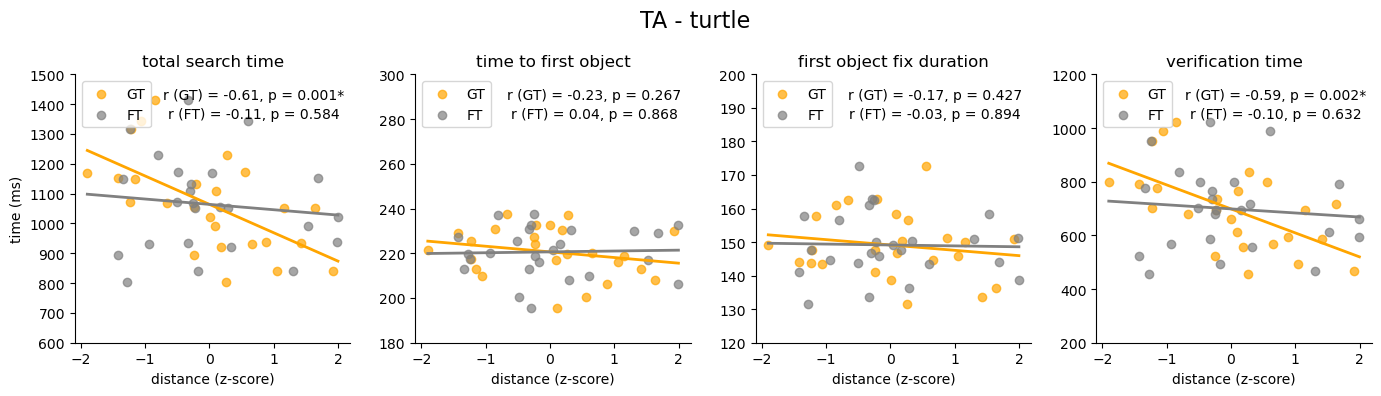

In [48]:
SAVE_FIG = True
print_correlation = True
TAP_list = ['TA']
GUIDANCE_MEASURES = ['total_search_time', 'time_to_first_object', 'first_object_fix_duration','verification_time'] # 'initial_saccade_latency',
target = 'turtle'

def remove_outliers_pair(x, y, threshold=3):
    """
    Remove paired outliers based on a z-score threshold.
    Only keep pairs where both x and y are within the threshold.
    """
    x = np.array(x)
    y = np.array(y)
    z_x = np.abs((x - np.mean(x)) / np.std(x))
    z_y = np.abs((y - np.mean(y)) / np.std(y))
    mask = (z_x < threshold) & (z_y < threshold)
    return x[mask], y[mask]

# Create a subplot grid: rows = TAP groups, cols = guidance measures
fig, axs = plt.subplots(nrows=len(TAP_list), ncols=len(GUIDANCE_MEASURES),
                        figsize=(3.5 * len(GUIDANCE_MEASURES), 3.5 * len(TAP_list)+0.5),
                        squeeze=False)

for i, TAP in enumerate(TAP_list):
    if TAP == 'Combined':
        fdictlist_TAP = [fd for fd in fdictlist if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
    elif TAP == 'TP':
        fdictlist_TAP = [fd for fd in fdictlist_TP if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP
    elif TAP == 'TA':
        fdictlist_TAP = [fd for fd in fdictlist_TA if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TA
    else:
        raise NotImplementedError(f"Invalid TAP: {TAP}")
    
    if target != 'all':
        stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TAP))  
    else:
        stimuli_info_TAP_target = stimuli_info_TAP 
    print('# of stimuli:', len(stimuli_info_TAP_target))
     
    for j, gmeasure in enumerate(GUIDANCE_MEASURES):
        avg_measures = []
        our_scores = []
        cnn_scores = []
        
        # Loop over each stimulus
        for info in stimuli_info_TAP_target:
            imgid = info['display_idx']
            # Filter trials corresponding to this image
            trials = list(filter(lambda x: x['IMAGE_ID'] == imgid, fdictlist_TAP))
            if not trials:
                continue

            # Calculate average measure based on guidance measure
            if gmeasure == 'total_search_time':
                avg = np.nanmean([trial['REACTION_TIME'] for trial in trials])

            elif gmeasure == 'time_to_first_object':
                # avg = np.nanmean([trial['FIX_START'][0] for trial in trials])
                ms=[]
                for trial in trials:
                    roi_array = np.array(trial['ROI_LABELS'])
                    non_center_fix_idx = np.nonzero(roi_array != -1)[0]
                    if non_center_fix_idx.size > 0:
                        first_non_center_fix_idx = non_center_fix_idx[0]
                        # if roi_array[first_non_center_fix_idx] == int(info['target_idx_in_objlist']):
                        #     ms.append(trial['FIX_START'][first_non_center_fix_idx])
                        #first_non_center_fix_roi = roi_array[first_non_center_fix_idx]
                        ms.append(trial['FIX_START'][first_non_center_fix_idx])
                    else:
                        continue
                avg = np.nanmean(ms)


            elif gmeasure == 'first_object_fix_duration':
                ms = []
                for trial in trials:
                    roi_array = np.array(trial['ROI_LABELS'])
                    non_center_fix_idx = np.nonzero(roi_array != -1)[0]
                    if non_center_fix_idx.size > 0:
                        first_non_center_fix_idx = non_center_fix_idx[0]
                        ms.append(trial['FIX_DURATION'][first_non_center_fix_idx])
                    else:
                        continue
                avg = np.nanmean(ms)
            
            elif gmeasure == 'verification_time':
                ms = []
                for trial in trials:
                    roi_array = np.array(trial['ROI_LABELS'])
                    non_center_fix_idx = np.nonzero(roi_array != -1)[0]
                    if non_center_fix_idx.size > 0:
                        first_non_center_fix_idx = non_center_fix_idx[0]
                        time_target = trial['FIX_START'][first_non_center_fix_idx] + trial['FIX_DURATION'][first_non_center_fix_idx]
                        ms.append(trial['REACTION_TIME'] - time_target)
                    else:
                        continue
                avg = np.nanmean(ms)
            
            else:
                raise NotImplementedError(f"Invalid guidance measure: {gmeasure}")
                
            avg_measures.append(avg)
            our_scores.append(-GC_BUDGET*(np.mean(info['our_priority_raw'])))
            cnn_scores.append(-(np.mean(info['cnn_priority_raw'])))

            # our_scores.append(entropy(info['our_priority']))
            # cnn_scores.append(entropy(info['cnn_priority']))



            #our_scores.append(-GC_BUDGET*np.sort(info['our_priority_raw'])[-1]) # second highest priority
            #cnn_scores.append(-np.sort(info['cnn_priority_raw'])[-1]) # second highest priority
        
        # Remove outliers from each paired dataset
        # Here, avg_measures (y) vs. our_scores/cnn_scores (x)
        avg_clean_our, our_clean = remove_outliers_pair(avg_measures, our_scores, threshold=3)
        avg_clean_cnn, cnn_clean = remove_outliers_pair(avg_measures, cnn_scores, threshold=3)
        
        # Standardize the x-measures (our_clean and cnn_clean) using z-score normalization
        our_clean_norm = (our_clean - np.mean(our_clean)) / np.std(our_clean)
        cnn_clean_norm = (cnn_clean - np.mean(cnn_clean)) / np.std(cnn_clean)
        
        # Calculate Pearson correlations on the normalized x-measures
        corr_our, pval_our = pearsonr(our_clean_norm, avg_clean_our)
        corr_cnn, pval_cnn = pearsonr(cnn_clean_norm, avg_clean_cnn)
        
        # Select the appropriate subplot axis
        ax = axs[i, j]
        
        # Plot scatter points with normalized x-values ("distance") and guidance measure ("time")
        ax.scatter(our_clean_norm, avg_clean_our, alpha=0.7, color='orange', label='GT')
        ax.scatter(cnn_clean_norm, avg_clean_cnn, alpha=0.7, color='gray', label='FT')
        
        # Compute and plot regression lines using normalized x-values
        slope_our, intercept_our = np.polyfit(our_clean_norm, avg_clean_our, 1)
        slope_cnn, intercept_cnn = np.polyfit(cnn_clean_norm, avg_clean_cnn, 1)
        x_vals = np.linspace(min(our_clean_norm.min(), cnn_clean_norm.min()),
                             max(our_clean_norm.max(), cnn_clean_norm.max()), 100)
        ax.plot(x_vals, slope_our * x_vals + intercept_our, color='orange', linewidth=2)
        ax.plot(x_vals, slope_cnn * x_vals + intercept_cnn, color='gray', linewidth=2)
        
        if gmeasure == 'total_search_time':
            ax.set_ylim(600, 1500)      # 0.5–1.5 s
        elif gmeasure == 'time_to_first_object':
            ax.set_ylim(180, 300)       # 0.1–0.7 s
        elif gmeasure == 'first_object_fix_duration':
            ax.set_ylim(120, 200)
        elif gmeasure == 'verification_time':
            ax.set_ylim(200, 1200)

        # Set subplot title to indicate TAP group and guidance measure
        title_map = {
            'total_search_time': 'total search time',
            'time_to_first_object': 'time to first object',
            'first_object_fix_duration': 'first object fix duration',
            'verification_time': 'verification time'
        }
        ax.set_title(f"{title_map[gmeasure]}")
        
        # Set x-label only on the bottom row and y-label only on the first column
        if i == len(TAP_list) - 1:
            ax.set_xlabel("distance (z-score)")
        if j == 0:
            ax.set_ylabel("time (ms)")
        
        ax.legend(loc='upper left')
        
        # Remove top and right spines for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if print_correlation:
            sig_our = '*' if pval_our < 0.05 else ''
            sig_cnn = '*' if pval_cnn < 0.05 else ''
            ax.text(0.65, 0.95, f"r (GT) = {corr_our:.2f}, p = {pval_our:.3f}{sig_our}",
                    transform=ax.transAxes, verticalalignment='top', ha='center')
            ax.text(0.65, 0.88, f"r (FT) = {corr_cnn:.2f}, p = {pval_cnn:.3f}{sig_cnn}",
                    transform=ax.transAxes, verticalalignment='top', ha='center')
plt.suptitle(f'{TAP} - {target}', fontsize=16)
plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f'../figures/savefig/TA_guidance_corr_{target}_{IMAGE_TYPE}_{"wcorr" if print_correlation else "nocorr"}.png', dpi=300, bbox_inches='tight')
plt.show()


# category wise analysis

In [11]:
import itertools
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

def run_stats(avg_measures_by_target, alpha=0.05):
    """
    avg_measures_by_target : dict  { 'dog': [vals…], 'bird': [vals…], … }
                              Use the trial- or image-level values (NOT the already-averaged means).
    alpha : family-wise error rate you want to control.
    """
    # 1) ---------- one-way ANOVA ----------
    groups = [v for v in avg_measures_by_target.values()]
    f_stat, p_anova = stats.f_oneway(*groups)
    print(f"ONE-WAY ANOVA  F({len(groups)-1}, {sum(map(len,groups))-len(groups)}) = "
          f"{f_stat:.2f},  p = {p_anova:.4g}")

    # 2) ---------- pair-wise tests ----------
    pairs, t_vals, p_vals, bigger = [], [], [], []
    for a, b in itertools.combinations(avg_measures_by_target.keys(), 2):
        x, y = avg_measures_by_target[a], avg_measures_by_target[b]
        t, p = stats.ttest_ind(x, y, equal_var=False, nan_policy='omit')
        pairs.append((a, b))
        t_vals.append(t)
        p_vals.append(p)
        bigger.append(a if np.nanmean(x) > np.nanmean(y) else b)

    # Bonferroni correction
    reject, p_corr, _, _ = multipletests(p_vals, alpha=alpha, method='bonferroni')

    # Nicely formatted report
    print("\nPAIR-WISE COMPARISONS (Bonferroni-adjusted α = {:.3f})".format(alpha))
    for (a,b), t, p_unc, p_bonf, r in zip(pairs, t_vals, p_vals, p_corr, reject):
        star = "✓" if r else "n.s."
        direction = f"{bigger[pairs.index((a,b))]} larger" if r else ""
        print(f"{a:>7} vs {b:<7} | t = {t:+.2f} | p_unc={p_unc:.4g} | p_adj={p_bonf:.4g} | {star} {direction}")


Processing Combined...
# of dog stimuli: 36
# of bird stimuli: 45
# of insect stimuli: 47
# of turtle stimuli: 50

 =========== run on avg measures
ONE-WAY ANOVA  F(3, 174) = 9.29,  p = 9.887e-06

PAIR-WISE COMPARISONS (Bonferroni-adjusted α = 0.050)
    dog vs bird    | t = +0.40 | p_unc=0.6938 | p_adj=1 | n.s. 
    dog vs insect  | t = +1.31 | p_unc=0.1941 | p_adj=1 | n.s. 
    dog vs turtle  | t = -3.44 | p_unc=0.0009051 | p_adj=0.005431 | ✓ turtle larger
   bird vs insect  | t = +0.79 | p_unc=0.4315 | p_adj=1 | n.s. 
   bird vs turtle  | t = -3.61 | p_unc=0.0004979 | p_adj=0.002988 | ✓ turtle larger
 insect vs turtle  | t = -4.91 | p_unc=4.074e-06 | p_adj=2.445e-05 | ✓ turtle larger
        TAP Target        Metric        Mean        SEM
0  Combined    dog      avg_accs    0.966564   0.016902
1  Combined    dog  avg_measures  849.040047  23.579153
2  Combined    dog    our_scores   23.194869   1.106954
3  Combined    dog    cnn_scores   18.595436   0.194599
4  Combined   bird      

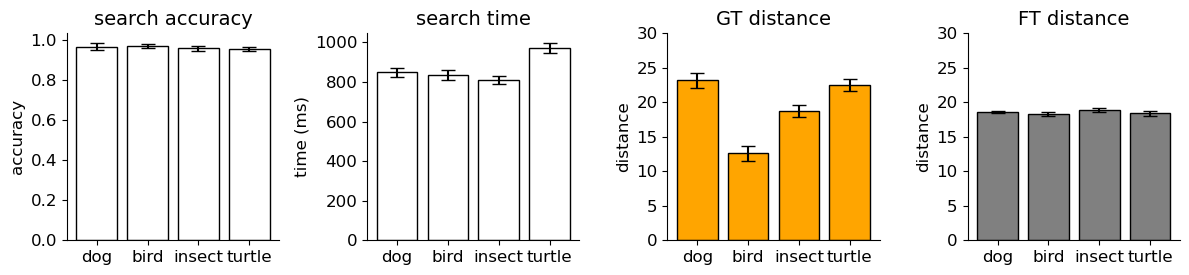

Processing TP...
# of dog stimuli: 11
# of bird stimuli: 20
# of insect stimuli: 22
# of turtle stimuli: 25

 =========== run on avg measures
ONE-WAY ANOVA  F(3, 74) = 9.34,  p = 2.608e-05

PAIR-WISE COMPARISONS (Bonferroni-adjusted α = 0.050)
    dog vs bird    | t = +2.23 | p_unc=0.0385 | p_adj=0.231 | n.s. 
    dog vs insect  | t = +2.40 | p_unc=0.02921 | p_adj=0.1753 | n.s. 
    dog vs turtle  | t = -1.40 | p_unc=0.174 | p_adj=1 | n.s. 
   bird vs insect  | t = +0.08 | p_unc=0.9354 | p_adj=1 | n.s. 
   bird vs turtle  | t = -4.09 | p_unc=0.0001948 | p_adj=0.001169 | ✓ turtle larger
 insect vs turtle  | t = -4.38 | p_unc=8.789e-05 | p_adj=0.0005274 | ✓ turtle larger
  TAP Target        Metric        Mean        SEM
0  TP    dog      avg_accs    0.968013   0.013468
1  TP    dog  avg_measures  809.782572  34.934503
2  TP    dog    our_scores   16.793497   1.686433
3  TP    dog    cnn_scores   17.874521   0.330823
4  TP   bird      avg_accs    0.972222   0.010009


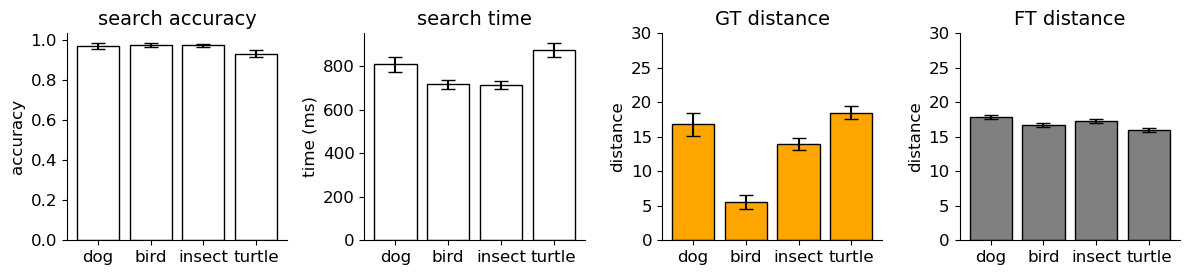

Processing TA...
# of dog stimuli: 25
# of bird stimuli: 25
# of insect stimuli: 25
# of turtle stimuli: 25

 =========== run on avg measures
ONE-WAY ANOVA  F(3, 96) = 8.29,  p = 5.88e-05

PAIR-WISE COMPARISONS (Bonferroni-adjusted α = 0.050)
    dog vs bird    | t = -1.36 | p_unc=0.1806 | p_adj=1 | n.s. 
    dog vs insect  | t = -0.63 | p_unc=0.5335 | p_adj=1 | n.s. 
    dog vs turtle  | t = -4.51 | p_unc=4.23e-05 | p_adj=0.0002538 | ✓ turtle larger
   bird vs insect  | t = +0.90 | p_unc=0.3739 | p_adj=1 | n.s. 
   bird vs turtle  | t = -2.84 | p_unc=0.006557 | p_adj=0.03934 | ✓ turtle larger
 insect vs turtle  | t = -4.31 | p_unc=8.852e-05 | p_adj=0.0005311 | ✓ turtle larger
  TAP Target        Metric        Mean        SEM
0  TA    dog      avg_accs    0.965926   0.023804
1  TA    dog  avg_measures  866.313336  30.051966
2  TA    dog    our_scores   26.011473   0.984891
3  TA    dog    cnn_scores   18.912636   0.213867
4  TA   bird      avg_accs    0.967393   0.015687


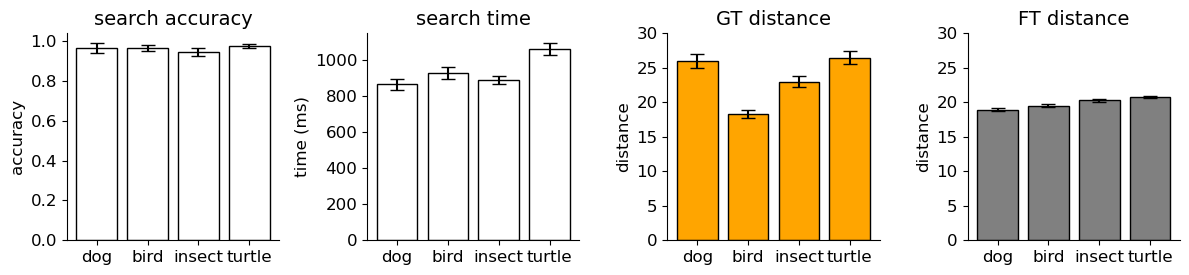

In [20]:
# category wise search time
# plt.style.use('default')
# Settings
SAVE_FIG = False
TAP_list = ['Combined', 'TP', 'TA']
GUIDANCE_MEASURES = ['total_search_time']  # can add more if needed
target = 'all'
TARGET_CATEGORIES = ['dog', 'bird', 'insect', 'turtle']  # define your target categories

# Prepare a list to collect summary statistics


for i, TAP in enumerate(TAP_list):
    summary_list = []
    print(f'Processing {TAP}...')
    if TAP == 'Combined':
        fdictlist_TAP = fdictlist
        stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
    elif TAP == 'TP':
        fdictlist_TAP = fdictlist_TP
        stimuli_info_TAP = stimuli_info_TP
    elif TAP == 'TA':
        fdictlist_TAP =fdictlist_TA
        stimuli_info_TAP = stimuli_info_TA
    else:
        raise NotImplementedError(f"Invalid TAP: {TAP}")
    
    # Loop over each target category
    target_measures = {}
    
    for target in TARGET_CATEGORIES:
        stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TAP))
        print(f'# of {target} stimuli:', len(stimuli_info_TAP_target))
         
        # Loop over each guidance measure (here, just one)
        for j, gmeasure in enumerate(GUIDANCE_MEASURES):
            avg_accs =[]
            avg_measures = []
            our_scores = []
            cnn_scores = []
            
            # Loop over each stimulus for this target
            
            for info in stimuli_info_TAP_target:
                imgid = info['display_idx']
                # average accuracy measure
                accs = [fd['ACC'] for fd in fdictlist_TAP if fd['IMAGE_ID'] == imgid]
                avg_accs.append(np.nanmean(accs))

                # average time measure over accurate trials
                # Filter trials corresponding to this image
                trials = list(filter(lambda x: (x['IMAGE_ID'] == imgid) and (x['ACC']==True), fdictlist_TAP))
                if not trials:
                    continue

                # Calculate average measure based on the guidance measure
                if gmeasure == 'total_search_time':
                    avg = np.nanmean([trial['REACTION_TIME'] for trial in trials])
                elif gmeasure == 'time_to_target':
                    ms = []
                    for trial in trials:
                        roi_target = np.array(trial['ROI_LABELS']) == int(info['target_idx_in_objlist'])
                        matching_indices = np.nonzero(roi_target)[0]
                        if matching_indices.size > 0:
                            first_index = matching_indices[0]
                            time_target = trial['FIX_START'][first_index]
                            ms.append(time_target)
                    avg = np.nanmean(ms)
                elif gmeasure == 'first_target_fix_duration':
                    ms = []
                    for trial in trials:
                        roi_target = np.array(trial['ROI_LABELS']) == int(info['target_idx_in_objlist'])
                        matching_indices = np.nonzero(roi_target)[0]
                        if matching_indices.size > 0:
                            first_index = matching_indices[0]
                            time_target = trial['FIX_DURATION'][first_index]
                            ms.append(time_target)
                    avg = np.nanmean(ms)
                elif gmeasure == 'verification_time':
                    ms = []
                    for trial in trials:
                        roi_target = np.array(trial['ROI_LABELS']) == int(info['target_idx_in_objlist'])
                        matching_indices = np.nonzero(roi_target)[0]
                        if matching_indices.size > 0:
                            first_index = matching_indices[0]
                            time_target = trial['FIX_START'][first_index] + trial['FIX_DURATION'][first_index]
                            ms.append(trial['REACTION_TIME'] - time_target)
                    avg = np.nanmean(ms)
                else:
                    raise NotImplementedError(f"Invalid guidance measure: {gmeasure}")
                    
                avg_measures.append(avg)
                target_measures.setdefault(target, []).append(avg)
                # Compute our and cnn scores for the target using the target index

                os_target = np.max(info['our_priority_raw'])
                cs_target = np.max(info['cnn_priority_raw'])
                our_scores.append(-GC_BUDGET * os_target)
                cnn_scores.append(-cs_target)

            
            # Compute summary statistics (mean and SEM) if we have any values
            if len(avg_accs) > 0:
                mean_acc = np.nanmean(avg_accs)
                sem_acc = np.nanstd(avg_accs) / np.sqrt(len(avg_accs)-1)
            else:
                mean_acc, sem_acc = np.nan, np.nan

            if len(avg_measures) > 0:
                mean_avg = np.nanmean(avg_measures)
                sem_avg = np.nanstd(avg_measures) / np.sqrt(len(avg_measures)-1)
            else:
                mean_avg, sem_avg = np.nan, np.nan
            if len(our_scores) > 0:
                mean_our = np.nanmean(our_scores)
                sem_our = np.nanstd(our_scores) / np.sqrt(len(our_scores)-1)
            else:
                mean_our, sem_our = np.nan, np.nan
            if len(cnn_scores) > 0:
                mean_cnn = np.nanmean(cnn_scores)
                sem_cnn = np.nanstd(cnn_scores) / np.sqrt(len(cnn_scores)-1)
            else:
                mean_cnn, sem_cnn = np.nan, np.nan
            
            # Append results for this target and guidance measure
            summary_list.append({'TAP': TAP, 'Target': target, 'Metric': 'avg_accs', 'Mean': mean_acc, 'SEM': sem_acc})
            summary_list.append({'TAP': TAP, 'Target': target, 'Metric': 'avg_measures', 'Mean': mean_avg, 'SEM': sem_avg})
            summary_list.append({'TAP': TAP, 'Target': target, 'Metric': 'our_scores', 'Mean': mean_our, 'SEM': sem_our})
            summary_list.append({'TAP': TAP, 'Target': target, 'Metric': 'cnn_scores', 'Mean': mean_cnn, 'SEM': sem_cnn})

    # run categorywise stats on avg measures
    print('\n =========== run on avg measures')
    run_stats(target_measures)

    # Convert summary list to DataFrame
    df_summary = pd.DataFrame(summary_list)
    print(df_summary.head())

    # Define color mapping for each metric
    color_map = {
        'avg_accs': 'white',
        'avg_measures': 'white',
        'our_scores': 'orange',
        'cnn_scores': 'gray'
    }

    # Define title mapping for each metric
    title_map = {
        'avg_accs': 'search accuracy',
        'avg_measures': 'search time',
        'our_scores': 'GT distance',
        'cnn_scores': 'FT distance'
    }

    # Define y-axis label mapping for each metric
    y_label_map = {
        'avg_accs': 'accuracy',
        'avg_measures': 'time (ms)',
        'our_scores': 'distance',
        'cnn_scores': 'distance'
    }

    # Now plot barplots for each metric across target categories with updated settings
    metrics = ['avg_accs','avg_measures', 'our_scores', 'cnn_scores']
    fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=False)

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        # Filter data for the current metric and order targets if desired
        df_metric = df_summary[df_summary['Metric'] == metric]
        df_metric = df_metric.set_index('Target').loc[TARGET_CATEGORIES].reset_index()
        
        # Draw barplot with error bars and updated color
        bars = ax.bar(df_metric['Target'], df_metric['Mean'],
                    yerr=df_metric['SEM'], capsize=5,
                    color=color_map[metric], edgecolor='black')
        
        # Set custom title and y-axis label
        ax.set_title(title_map[metric], fontsize=14)
        #ax.set_xlabel("Target Category", fontsize=12)
        ax.set_ylabel(y_label_map[metric], fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if metric == 'our_scores' or metric == 'cnn_scores':
            # Set y-axis limits for accuracy
            ax.set_ylim(0, 30)


    # plt.suptitle("Target-wise Comparison of avg_measures, our_scores, and cnn_scores", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if SAVE_FIG:
        plt.savefig(f"../figures/savefig/{TAP}_category_wise_{GUIDANCE_MEASURES[0]}_and_distance_{IMAGE_TYPE}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [16]:
target_measures

{'dog': [827.4814814814815,
  703.6296296296297,
  936.4074074074074,
  777.0754716981132,
  831.574074074074,
  706.074074074074,
  769.1481481481482,
  1035.5882352941176,
  808.0377358490566,
  870.0370370370371,
  1192.037037037037,
  718.9629629629629,
  904.8888888888889,
  816.8867924528302,
  779.6851851851852,
  927.8888888888889,
  959.2916666666666,
  734.9629629629629,
  818.1296296296297,
  1084.3181818181818,
  940.5,
  1269.1538461538462,
  709.8703703703703,
  802.0370370370371,
  734.1666666666666],
 'bird': [998.8518518518518,
  795.6666666666666,
  1607.5526315789473,
  773.6666666666666,
  913.4807692307693,
  891.0,
  817.1666666666666,
  1073.0,
  851.0185185185185,
  985.8148148148148,
  987.425925925926,
  935.8301886792453,
  785.9230769230769,
  1055.7962962962963,
  797.9074074074074,
  871.3018867924528,
  869.1666666666666,
  1088.0,
  821.1698113207547,
  851.6481481481482,
  1097.179487179487,
  803.3888888888889,
  792.433962264151,
  959.5555555555555,


ONE-WAY ANOVA  F(3, 96) = 8.29,  p = 5.88e-05

PAIR-WISE COMPARISONS (Bonferroni-adjusted α = 0.050)
    dog vs bird    | t = -1.36 | p_unc=0.1806 | p_adj=1 | n.s. 
    dog vs insect  | t = -0.63 | p_unc=0.5335 | p_adj=1 | n.s. 
    dog vs turtle  | t = -4.51 | p_unc=4.23e-05 | p_adj=0.0002538 | ✓ turtle larger
   bird vs insect  | t = +0.90 | p_unc=0.3739 | p_adj=1 | n.s. 
   bird vs turtle  | t = -2.84 | p_unc=0.006557 | p_adj=0.03934 | ✓ turtle larger
 insect vs turtle  | t = -4.31 | p_unc=8.852e-05 | p_adj=0.0005311 | ✓ turtle larger


# of dog stimuli: 11
# of bird stimuli: 20
# of insect stimuli: 22
# of turtle stimuli: 25
  TAP Target Model   Distance
0  TP    dog    GC  23.921227
1  TP    dog    TM  17.233891
2  TP    dog    GC  13.845890
3  TP    dog    TM  17.558180
4  TP    dog    GC  12.325724
   Target Model  Mean_Distance  SD_Distance  Count  SE_Distance
0    bird    GC       5.559844     4.674556     20     1.045262
1    bird    TM      16.722456     1.442247     20     0.322496
2     dog    GC      16.793497     5.593265     11     1.686433
3     dog    TM      17.874522     1.097216     11     0.330823
4  insect    GC      13.967166     4.223753     22     0.900507
5  insect    TM      17.293501     1.230638     22     0.262373
6  turtle    GC      18.477089     4.703138     25     0.940628
7  turtle    TM      16.013005     1.639681     25     0.327936


/tmp/ipykernel_293197/642600392.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=df_bar, x='Target', y='Distance', hue='Model',


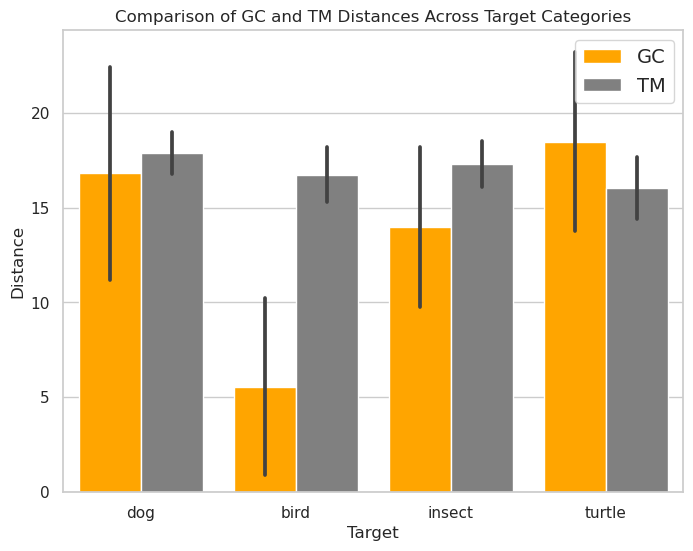

In [73]:
SAVE_FIG= False
TAP_list = ['TP']


# Prepare an empty list to collect the data for the barplot
data = []  # Each element is a dict with keys: 'TAP', 'Target', 'Model', 'Distance'

# Loop over TAP groups and target categories
for TAP in TAP_list:
    if TAP == 'Combined':
        fdictlist_TAP = [fd for fd in fdictlist if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
    elif TAP == 'TP':
        fdictlist_TAP = [fd for fd in fdictlist_TP if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP
    elif TAP == 'TA':
        fdictlist_TAP = [fd for fd in fdictlist_TA if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TA
    else:
        raise NotImplementedError(f"Invalid TAP: {TAP}")
    
    for target in TARGET_CATEGORIES:
        # Filter for stimuli with the current target category
        stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TAP))
        print(f'# of {target} stimuli:', len(stimuli_info_TAP_target))
    
        # For each stimulus, compute our and cnn distance for the target
        for info in stimuli_info_TAP_target:
            # Convert raw priority lists to numpy arrays for indexing
            our_priority = np.array(info['our_priority_raw'])
            cnn_priority = np.array(info['cnn_priority_raw'])
            # Compute distance (here multiplied by -GC_BUDGET for our and negative for cnn)
            our_distance = -GC_BUDGET * our_priority
            cnn_distance = -cnn_priority
            target_idx = info['target_idx_in_objlist']
            target_distance_our = our_distance[target_idx]
            target_distance_cnn = cnn_distance[target_idx]
            
            # Append data for both models
            data.append({'TAP': TAP, 'Target': target, 'Model': 'GC', 'Distance': target_distance_our})
            data.append({'TAP': TAP, 'Target': target, 'Model': 'TM', 'Distance': target_distance_cnn})


# Convert the list of dictionaries into a DataFrame
df_bar = pd.DataFrame(data)
print(df_bar.head())

# Optionally, compute summary statistics per target and model (mean, standard error, etc.)
summary = df_bar.groupby(['Target', 'Model']).agg(
    Mean_Distance=('Distance', 'mean'),
    SD_Distance=('Distance', 'std'),
    Count=('Distance', 'count')
).reset_index()
summary['SE_Distance'] = summary['SD_Distance'] / np.sqrt(summary['Count'])
print(summary)

# Plotting the barplot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_bar, x='Target', y='Distance', hue='Model',
                 ci='sd',  # error bars showing standard deviation (or use estimator=np.mean with custom error)
                 palette={'GC': 'orange', 'TM': 'gray'},
                 saturation=1)

plt.xlabel("Target")
plt.ylabel("Distance")
plt.title("Comparison of GC and TM Distances Across Target Categories")

# Make the legend bigger and place it inside the figure if desired
leg = plt.legend(title='', loc='upper right', fontsize=14)
leg.get_frame().set_facecolor('white')

if SAVE_FIG:
    plt.savefig(f"../figures/savefig/categorywise_distance_{IMAGE_TYPE}.png", dpi=300, bbox_inches='tight')
plt.show()

# center of gravity



In [256]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
from scipy.stats import ttest_rel
import pandas as pd

SAVE_FIG = False
TAP_list = ['TP'] # ,'TP' 'TA'
target = 'turtle'
DISPLAY_SIZE = (1050, 1680)  # display_height, display_width 
x_offset = int((DISPLAY_SIZE[1] - DISPLAY_SIZE[0]) / 2)
VISUALIZE = False
# Initialize results list to store average fixation distances.
fixation_distance_results = []
XMEASURE = 'com'

for TAP in TAP_list:
    if TAP == 'Combined':
        fdictlist_TAP = [fd for fd in fdictlist if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
    elif TAP == 'TP':
        fdictlist_TAP = [fd for fd in fdictlist_TP if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP
    elif TAP == 'TA':
        fdictlist_TAP = [fd for fd in fdictlist_TA if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TA
    else:
        raise NotImplementedError(f"Invalid TAP: {TAP}")
    
    if target != 'all':
        stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TAP))  
    else:
        stimuli_info_TAP_target = stimuli_info_TAP 
    print('# of stimuli:', len(stimuli_info_TAP_target))
     
    avg_measures = []
    our_scores = []
    cnn_scores = []
    
    # Loop over each stimulus
    for j, info in enumerate(stimuli_info_TAP_target):
        imgid = info['display_idx']
        # Filter trials corresponding to this image
        if info['target_idx_in_objlist'] is not None:
            targetid= info['target_idx_in_objlist']
        else:
            targetid= random.sample([0,1,2,3], k=1)[0]
        trials = list(filter(lambda x: x['IMAGE_ID'] == imgid, fdictlist_TAP))
        if not trials:
            continue

        fix_x_on_target = []
        fix_y_on_target = []

        # Get fixation coordinates for the target using ROI_LABELS match with target index.
        for trial in trials:
            roi_target = np.array(trial['ROI_LABELS']) == int(targetid)
            matching_indices = np.nonzero(roi_target)[0]
            
            # if matching_indices.size > 0:
            #     for index in matching_indices:
            #         fix_x_on_target.append(trial['FIX_X'][index] - x_offset)
            #         fix_y_on_target.append(trial['FIX_Y'][index])
            # else:
            #     continue
        
            #only first
            if matching_indices.size > 0:
                first_index = matching_indices[0]
                fix_x_on_target.append(trial['FIX_X'][first_index] - x_offset)
                fix_y_on_target.append(trial['FIX_Y'][first_index])
            else:
                continue

        # target bbox from info. Assume format is [x, y, x_max, y_max]
        bboxlist = info['bboxlist']
        target_bbox = bboxlist[targetid]
        
        # Unpack the bbox and convert to int if needed
        bbox_x, bbox_y, bbox_x_max, bbox_y_max = [int(v) for v in target_bbox]
        bbox_w = bbox_x_max - bbox_x
        bbox_h = bbox_y_max - bbox_y

        # Load the full image (priority map in this example)
        filename = info['display_filename']
        priority_path = f'../exp-source/our_priority_maps_{IMAGE_TYPE}/{filename}.png'
        priority = plt.imread(priority_path)
        cropped_priority = priority[bbox_y:bbox_y+bbox_h, bbox_x:bbox_x+bbox_w]
        cropped_priority_gray = np.mean(cropped_priority, axis=2)

        
        # orig_image
        orig_object_path = info['clean_objlist'][targetid]
        orig_obj = plt.imread(orig_object_path)  
        # orig_width, orig_height = orig_obj.shape[0], orig_obj.shape[1]
        

        # modified img
        ores = list(filter(lambda x: x['display_idx']==imgid, our_results))[0]
        modified_object_path = ores['modified_objlist'][targetid]
        modified_obj = Image.open(modified_object_path) 
        #modified_obj = plt.imread(modified_object_path)      
        BACKGROUND_COLOR= 128
        orig_width, orig_height = bbox_w, bbox_h
        mod_width, mod_height = modified_obj.size  # it's resized to 256, then center cropped to fit the model to 224, so we have to resize it back to the original size 
        padded_modified_obj = Image.new('RGB', (256, 256), color=(BACKGROUND_COLOR, BACKGROUND_COLOR, BACKGROUND_COLOR))
        padded_modified_obj.paste(modified_obj, ((orig_width-mod_width)// 2, (orig_height-mod_height)// 2))
        padded_modified_obj = padded_modified_obj.resize((orig_width, orig_height))



        # Load the mask image and adjust its path.
        mask_path = info['clean_objlist'][targetid]
        mask_path = mask_path.replace('imagenet_val_segmented_resized', 'imagenet_val_mask_resized')
        mask = plt.imread(mask_path)
        cropped_mask = mask
        cropped_mask_gray = cropped_mask
        # If the mask is RGB, uncomment the following line:
        # cropped_mask_gray = np.mean(cropped_mask, axis=2)

        # Adjust fixation coordinates so that (0,0) is the bbox top-left.
        fix_x_offset = [x - bbox_x for x in fix_x_on_target]
        fix_y_offset = [y - bbox_y for y in fix_y_on_target]
        fix_x_in_bbox = []
        fix_y_in_bbox = []
        for x, y in zip(fix_x_offset, fix_y_offset):
            if x < 0 or x > bbox_w or y < 0 or y > bbox_h:
                continue
            fix_x_in_bbox.append(x)
            fix_y_in_bbox.append(y)

        if XMEASURE == 'topk':
            #Find the top five maximum values in the cropped grayscale image and compute their center.
            topk=50
            top_indices = np.argsort(cropped_priority_gray , axis=None)[-topk:]
            top_coords = np.array(np.unravel_index(top_indices, cropped_priority_gray.shape)).T  # shape (5,2) with rows [y, x]
            center_top = np.mean(top_coords, axis=0)
            max_y, max_x = center_top
            print(f"Center of five max values: (x, y) = ({max_x:.2f}, {max_y:.2f})")
        
        elif XMEASURE == 'com':
            max_y, max_x = center_of_mass(cropped_priority_gray )
            print(f"Center of mass in priority (x, y) = ({com_x_mask}, {com_y_mask})")        

        elif XMEASURE == 'max':

            #Compute the very max value location in the cropped grayscale image.
            max_val = np.max(cropped_priority_gray)
            max_idx = np.argmax(cropped_priority_gray)
            max_y, max_x = np.unravel_index(max_idx, cropped_priority_gray.shape)
            print(f"Max value in image: {max_val} at (x, y) = ({max_x}, {max_y})")

            # # Compute the center of mass of the cropped grayscale image.
            # com_y_img, com_x_img = center_of_mass(cropped_gray)
            # print(f"Center of mass in image: (x, y) = ({com_x_img:.2f}, {com_y_img:.2f})")

            # # Calculate the midpoint between the max value location and the center of mass.
            # mid_x = (max_x + com_x_img) / 2
            # mid_y = (max_y + com_y_img) / 2
            # print(f"Midpoint between max value and center of mass: (x, y) = ({mid_x:.2f}, {mid_y:.2f})")
            
            # max_x = mid_x
            # max_y = mid_y
        else:
            raise ValueError(f"Invalid xmeasure: {XMEASURE}")

        # center of mass for mask
        com_y_mask, com_x_mask = center_of_mass(cropped_mask_gray)
        print(f"Center of mass in mask: (x, y) = ({com_x_mask}, {com_y_mask})")

        # center of bbox
        print(f"Center of bbox: (x, y) = ({int(bbox_w/2)}, {int(bbox_h/2)})")

        # Compute the average Euclidean distance for each condition (if there are fixations)
        if len(fix_x_in_bbox) > 0:
            fix_x_arr = np.array(fix_x_in_bbox)
            fix_y_arr = np.array(fix_y_in_bbox)
            # For cropped image, compute distances from max location
            dists_priority = np.sqrt((fix_x_arr - max_x)**2 + (fix_y_arr - max_y)**2)
            avg_distance_priority = np.mean(dists_priority)
            # For mask, compute distances from center of mass
            dists_mask = np.sqrt((fix_x_arr - com_x_mask)**2 + (fix_y_arr - com_y_mask)**2)
            avg_distance_mask = np.mean(dists_mask)
            dists_bbox = np.sqrt((fix_x_arr - int(bbox_w/2))**2 + (fix_y_arr -int(bbox_h/2))**2)
            avg_distance_bbox = np.mean(dists_bbox)
        else:
            avg_distance_priority = np.nan
            avg_distance_mask = np.nan
            avg_distance_bbox = np.nan

        # Store results for later statistical analysis.
        fixation_distance_results.append({
            'TAP': TAP,
            'display_idx': imgid,
            'filename': filename,
            'avg_distance_priority': avg_distance_priority,
            'avg_distance_mask': avg_distance_mask,
            'avg_distance_bbox': avg_distance_bbox,
            'num_fixations': len(fix_x_in_bbox)
        })

        # Create a side-by-side plot: left for cropped image, right for cropped mask.
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

        ax1.imshow(orig_obj)
        ax1.set_title(f"Original Target from {filename}")
        ax1.axis('off')


        ax2.imshow(padded_modified_obj)
        ax2.set_title(f"Generated Target from {filename}")
        ax2.axis('off')

        # Plot the cropped image with fixation dots and the max value.
        ax3.imshow(cropped_priority)
        ax3.scatter(fix_x_in_bbox, fix_y_in_bbox, c='b', marker='o', s=50, label='human fixation')
        ax3.scatter(max_x, max_y, c='red', marker='x', s=200, label='center of mass')
        ax3.legend()
        ax3.set_title(f"Priority Map Cropped on Target Region: {filename}")
        ax3.axis('off')

        # Plot the cropped mask with fixation dots and the center of mass.
        ax4.imshow(cropped_mask, cmap='gray' if cropped_mask.ndim == 2 else None)
        ax4.scatter(fix_x_in_bbox, fix_y_in_bbox, c='b', marker='o', s=50, label='human fixation')
        ax4.scatter(com_x_mask, com_y_mask, c='red', marker='x', s=200, label='center of mass')
        ax4.legend()
        ax4.set_title(f"Target Segmentation Mask: {filename}")
        ax4.axis('off')

        plt.tight_layout()

        if SAVE_FIG:
            plt.savefig(f'../figures/first_fix_on_target_{XMEASURE}/{TAP}_{target}_{targetid}_{filename}.png', dpi=300, bbox_inches='tight')
        
        if VISUALIZE:
            plt.show()
        else:
            plt.close()

        #Uncomment below to limit processing to a few images for debugging
        # if j > 10:
        #     break

# After processing all stimuli, compile results into a DataFrame and perform a paired t-test.
df_results = pd.DataFrame(fixation_distance_results)
print("Fixation Distance Results:")
print(df_results)

# Remove any rows with NaN values before running the t-test.
df_valid = df_results.dropna(subset=['avg_distance_priority', 'avg_distance_mask'])
if not df_valid.empty:

    print("\nPaired t-testt between cropped image and mask fixation distances:")
    print(f"average distance (priority map): {np.mean(df_valid['avg_distance_priority']):.2f}")

    t_stat, p_val = ttest_rel(df_valid['avg_distance_priority'], df_valid['avg_distance_bbox'])
    print(f"average distance (bbox): {np.mean(df_valid['avg_distance_bbox']):.2f}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)

    t_stat, p_val = ttest_rel(df_valid['avg_distance_priority'], df_valid['avg_distance_mask'])
    print(f"average distance (mask): {np.mean(df_valid['avg_distance_mask']):.2f}")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)


else:
    print("No valid data to perform t-test.")


# of stimuli: 25
Center of mass in priority (x, y) = (128.6401653963576, 110.94993133734526)
Center of mass in mask: (x, y) = (126.06541447519712, 120.9746967131655)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (126.06541447519712, 120.9746967131655)
Center of mass in mask: (x, y) = (116.21913467243033, 122.73104047089949)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (116.21913467243033, 122.73104047089949)
Center of mass in mask: (x, y) = (128.43923471234746, 116.31393257939797)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (128.43923471234746, 116.31393257939797)
Center of mass in mask: (x, y) = (113.20946958172217, 110.03832643452724)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (113.20946958172217, 110.03832643452724)
Center of mass in mask: (x, y) = (107.04743429799872, 106.8394088978295)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (107.04743429799

Center of mass in priority (x, y) = (117.39052205550736, 110.13676166149696)
Center of mass in mask: (x, y) = (122.05735911470305, 109.84687804653296)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (122.05735911470305, 109.84687804653296)
Center of mass in mask: (x, y) = (120.02098355877119, 125.59544483552246)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (120.02098355877119, 125.59544483552246)
Center of mass in mask: (x, y) = (118.89302000724608, 111.81419950887646)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (118.89302000724608, 111.81419950887646)
Center of mass in mask: (x, y) = (129.91256977014888, 101.80979507591674)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (129.91256977014888, 101.80979507591674)
Center of mass in mask: (x, y) = (121.03037311589172, 112.45756417458081)
Center of bbox: (x, y) = (120, 120)
Center of mass in priority (x, y) = (121.03037311589172, 112.4575

# of stimuli: 11


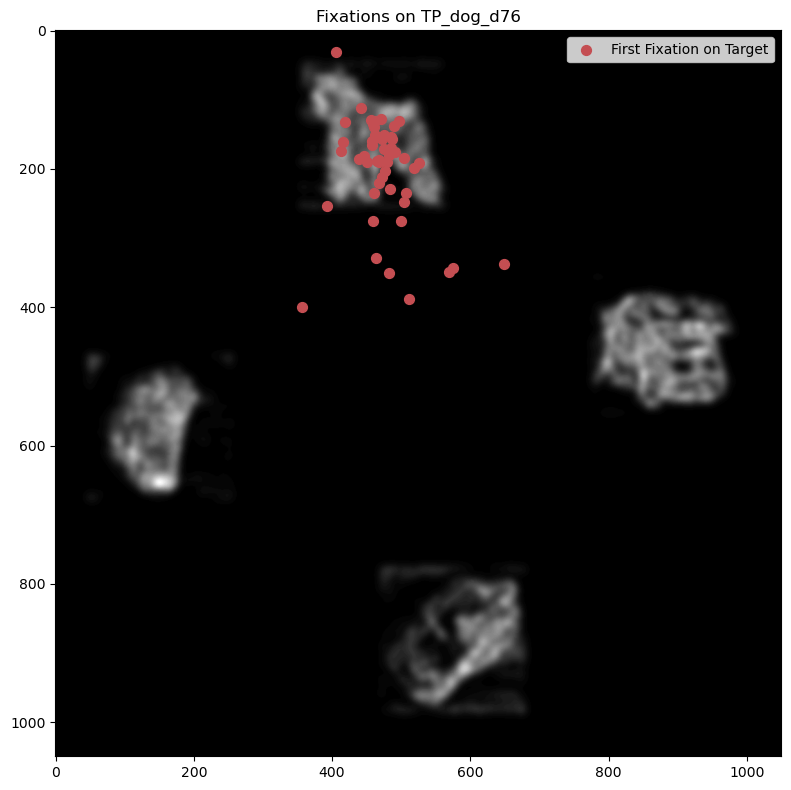

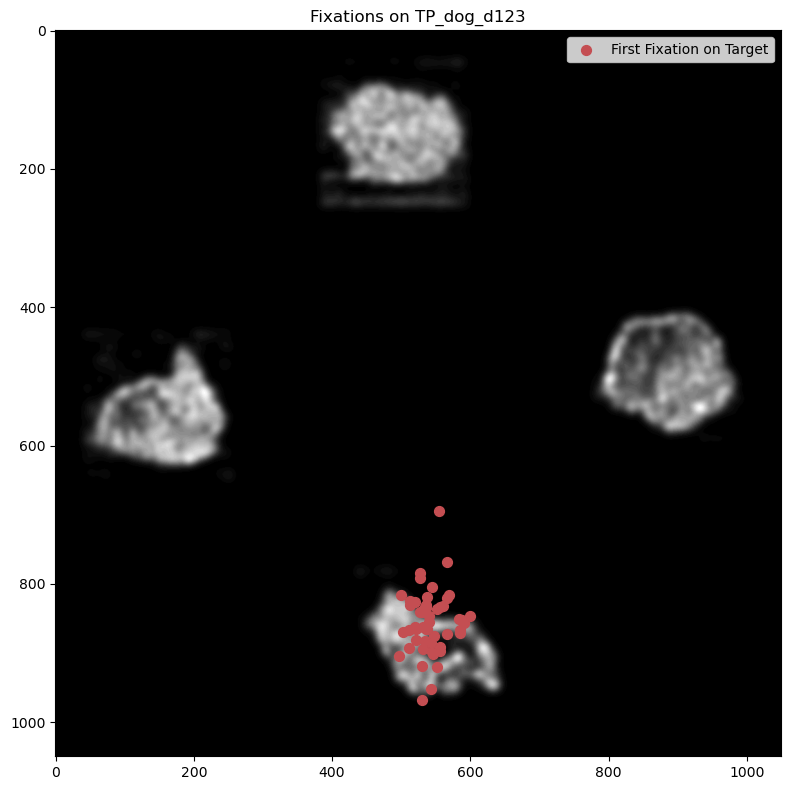

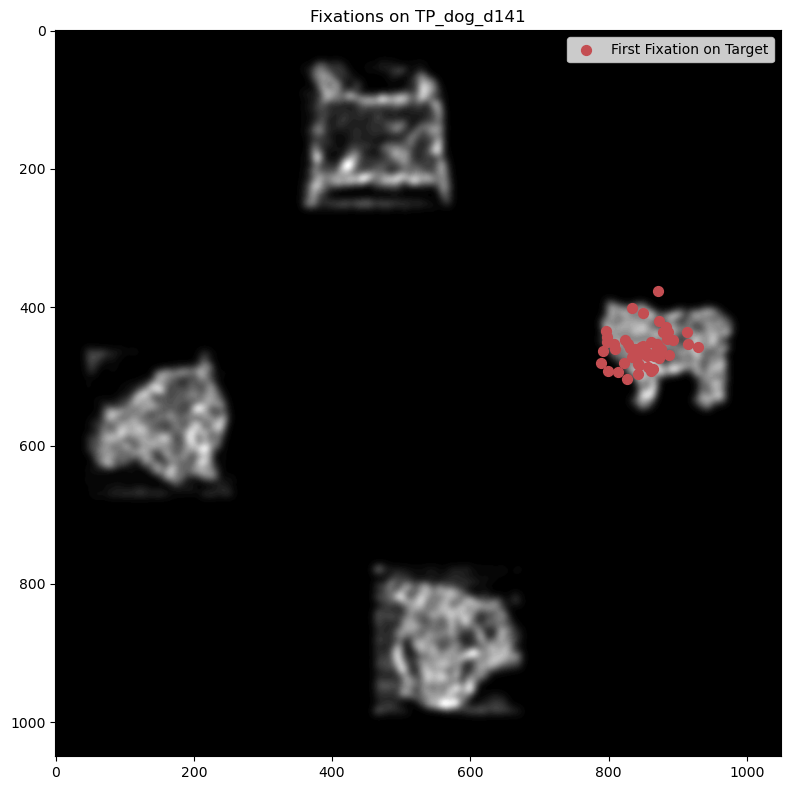

In [205]:
####
# first fixation on target visualization
#######
SAVE_FIG = False
TAP_list = ['TP']
target = 'dog'
DISPLAY_SIZE =  (1050, 1680) #display_height, display_width 
x_offset = int((DISPLAY_SIZE[1]-DISPLAY_SIZE[0])/2)


for i, TAP in enumerate(TAP_list):
    if TAP == 'Combined':
        fdictlist_TAP = [fd for fd in fdictlist if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
    elif TAP == 'TP':
        fdictlist_TAP = [fd for fd in fdictlist_TP if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TP
    elif TAP == 'TA':
        fdictlist_TAP = [fd for fd in fdictlist_TA if fd['ACC']]
        stimuli_info_TAP = stimuli_info_TA
    else:
        raise NotImplementedError(f"Invalid TAP: {TAP}")
    
    if target != 'all':
        stimuli_info_TAP_target = list(filter(lambda x: x['target_label'] == target, stimuli_info_TAP))  
    else:
        stimuli_info_TAP_target = stimuli_info_TAP 
    print('# of stimuli:', len(stimuli_info_TAP_target))
     
    avg_measures = []
    our_scores = []
    cnn_scores = []
    
    # Loop over each stimulus
    for i, info in enumerate(stimuli_info_TAP_target):
        imgid = info['display_idx']
        # Filter trials corresponding to this image
        trials = list(filter(lambda x: x['IMAGE_ID'] == imgid, fdictlist_TAP))
        if not trials:
            continue

        fix_x_on_target=[]
        fix_y_on_target=[]

        # for trial in trials:
        #     roi_array = np.array(trial['ROI_LABELS'])
        #     non_center_fix_idx = np.nonzero(roi_array != -1)[0]
        #     if non_center_fix_idx.size > 0:
        #         first_non_center_fix_idx = non_center_fix_idx[0]
        #         fix_x_on_target.append(trial['FIX_X'][first_non_center_fix_idx]-x_offset)
        #         fix_y_on_target.append(trial['FIX_Y'][first_non_center_fix_idx])
        #     else:
        #         continue
                

        for trial in trials:
            roi_target = np.array(trial['ROI_LABELS']) == int(info['target_idx_in_objlist'])
            matching_indices = np.nonzero(roi_target)[0]
            if matching_indices.size > 0:
                first_index = matching_indices[0]
                fix_x_on_target.append(trial['FIX_X'][first_index]-x_offset)
                fix_y_on_target.append(trial['FIX_Y'][first_index])
            else:
                continue

        # target bbox
        bboxlist = info['bboxlist']
        target_bbox = bboxlist[int(info['target_idx_in_objlist'])]
        
        ## code that draw dots on fix x, y location (which are in image coords) on priority map
        filename = info['display_filename']
        img_path =  f'../exp-source/our_priority_maps_{IMAGE_TYPE}/{filename}.png'

        img = plt.imread(img_path)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(img)
        
        # Overlay red dots for fixation coordinates
        ax.scatter(fix_x_on_target, fix_y_on_target, c='r', marker='o', s=50, label='First Fixation on Target')
        ax.legend()
        ax.set_title(f"Fixations on {info['display_filename']}")
        plt.tight_layout()
        
        if SAVE_FIG:
            fig.savefig(f'../figures/savefig/first_fix_on_target_{target}_{IMAGE_TYPE}.png', dpi=300, bbox_inches='tight')
        plt.show()

        if i > 1:
            break

# qualitative comparison

In [ ]:
# test['human_probs'] = test['human_probs'].apply(lambda x: np.array(x).round(2))
# test['our_probs'] = test['our_probs'].apply(lambda x: np.array(x).round(2))
# test['cnn_probs'] = test['cnn_probs'].apply(lambda x: np.array(x).round(2))
# test

,imgid,human_probs,our_probs,cnn_probs,our_corr,our_corr_pvalue,cnn_corr,cnn_corr_pvalue
0,76,"[0.79, 0.14, 0.04, 0.02]","[0.32, 0.32, 0.14, 0.21]","[0.64, 0.1, 0.06, 0.19]",0.657443,0.342557,0.962045,0.037955
1,123,"[0.09, 0.36, 0.54, 0.02]","[0.03, 0.04, 0.61, 0.31]","[0.13, 0.3, 0.53, 0.05]",0.523510,0.476490,0.989957,0.010043
2,141,"[0.02, 0.29, 0.01, 0.68]","[0.07, 0.09, 0.03, 0.82]","[0.14, 0.26, 0.09, 0.51]",0.927561,0.072439,0.994315,0.005685
3,180,"[0.12, 0.71, 0.04, 0.14]","[0.06, 0.86, 0.06, 0.02]","[0.05, 0.4, 0.29, 0.25]",0.985930,0.014070,0.639099,0.360901
4,184,"[0.04, 0.07, 0.82, 0.07]","[0.04, 0.04, 0.88, 0.04]","[0.38, 0.04, 0.54, 0.04]",0.999529,0.000471,0.759640,0.240360
...,...,...,...,...,...,...,...,...
73,1013,"[0.01, 0.59, 0.3, 0.1]","[0.05, 0.59, 0.1, 0.27]","[0.03, 0.79, 0.12, 0.05]",0.819570,0.180430,0.925420,0.074580
74,1032,"[0.9, 0.04, 0.0, 0.05]","[0.79, 0.09, 0.09, 0.03]","[0.51, 0.27, 0.03, 0.2]",0.992902,0.007098,0.886767,0.113233
75,1040,"[0.11, 0.01, 0.08, 0.79]","[0.03, 0.18, 0.09, 0.7]","[0.15, 0.05, 0.17, 0.63]",0.951693,0.048307,0.994020,0.005980
76,1045,"[0.13, 0.0, 0.02, 0.85]","[0.02, 0.02, 0.07, 0.9]","[0.01, 0.11, 0.03, 0.85]",0.985010,0.014990,0.972724,0.027276


In [ ]:
from PIL import Image, ImageDraw

# Directories and parameters
SAVE_FIG = True
VISUALIZE =False
PRIORTY_RESULTS_DIR = f'../results/correlation_w_human_priority_template_{IMAGE_TYPE}'
DISPLAY_SIZE = (1050, 1680)  # display_height, display_width 
X_OFFSET = int((DISPLAY_SIZE[1] - DISPLAY_SIZE[0]) / 2)

# Load the priority results dataframe
df_priority_TP = pd.read_pickle(f'{PRIORTY_RESULTS_DIR}/TP_priority_prob_corr_pearson_fall.pkl')
df_priority_TA = pd.read_pickle(f'{PRIORTY_RESULTS_DIR}/TA_priority_prob_corr_pearson_fall.pkl')
df_priority = pd.concat([df_priority_TP, df_priority_TA])

stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
print(f'stimuli #: {len(stimuli_info_TAP)}')
# Loop over each stimulus info
for info in tqdm(stimuli_info_TAP):
    display_idx = info['display_idx']
    display_filename = info['display_filename']
    bboxlist = info['bboxlist']

    # Load images
    orig_img = Image.open(f'../exp-source/display_{IMAGE_TYPE}/{display_filename}.png')
    gen_img = Image.open(f'../exp-source/display_{IMAGE_TYPE}_modified/{display_filename}.png')
    diff_map = Image.open(f'../exp-source/our_pixeldiff_maps_{IMAGE_TYPE}/{display_filename}.png')
    our_priority_map = Image.open(f'../exp-source/our_priority_maps_{IMAGE_TYPE}/{display_filename}.png')

    # --- Create Human Priority Map ---
    # Load trials with correct accuracy for this image
    trials = [fd for fd in fdictlist if (fd['IMAGE_ID'] == display_idx) and (fd['ACC'])]
    fix_xs = []
    fix_ys = []
    for trial in trials:
        fix_xs.extend(list(np.array(trial['FIX_X']) - X_OFFSET))
        fix_ys.extend(trial['FIX_Y'])

    # Create a copy of orig_img and overlay fixation points
    human_priority_map = orig_img.copy()
    if human_priority_map.mode != 'RGB':
        human_priority_map = human_priority_map.convert('RGB')
    draw = ImageDraw.Draw(human_priority_map)
    radius = 5
    for x, y in zip(fix_xs, fix_ys):
        leftUpPoint = (x - radius, y - radius)
        rightDownPoint = (x + radius, y + radius)
        draw.ellipse([leftUpPoint, rightDownPoint], fill='blue', outline='blue')

    # --- Create CNN Priority Map (black image) ---
    cnn_priority_map = Image.new('L', orig_img.size, 0)

    # --- Load Priority and Correlation Data ---
    human_priority = df_priority.loc[df_priority['imgid'] == display_idx, 'human_probs'].values[0]
    our_priority   = df_priority.loc[df_priority['imgid'] == display_idx, 'our_probs'].values[0]
    cnn_priority   = df_priority.loc[df_priority['imgid'] == display_idx, 'cnn_probs'].values[0]
    our_corr       = df_priority.loc[df_priority['imgid'] == display_idx, 'our_corr'].values[0]
    our_corr_p     = df_priority.loc[df_priority['imgid'] == display_idx, 'our_corr_pvalue'].values[0]
    cnn_corr       = df_priority.loc[df_priority['imgid'] == display_idx, 'cnn_corr'].values[0]
    cnn_corr_p     = df_priority.loc[df_priority['imgid'] == display_idx, 'cnn_corr_pvalue'].values[0]

    # Helper to format lists with 2 decimal points
    def format_list(lst):
        return ', '.join([f"{v:.2f}" for v in lst])

    human_priority_text = f"{format_list(human_priority)}"
    our_priority_text   = (f"{format_list(our_priority)}\n"
                           f"Corr: {our_corr:.2f} (p={our_corr_p:.2f})")
    cnn_priority_text   = (f"{format_list(cnn_priority)}\n"
                           f"Corr: {cnn_corr:.2f} (p={cnn_corr_p:.2f})")

    # --- Plotting ---
    fig, axes = plt.subplots(1, 6, figsize=(16, 4))

    # 1. Original Image
    axes[0].imshow(orig_img)
    axes[0].set_title("original image")
    axes[0].text(0.5, -0.1, f'img id: {display_idx}', transform=axes[0].transAxes,
                fontsize=10, ha='center', va='top')
    axes[0].axis('off')

    # 2. Human Priority Map (orig_img with fixations overlaid)
    axes[1].imshow(human_priority_map)
    axes[1].set_title("human fixations")
    axes[1].text(0.5, -0.1, human_priority_text, transform=axes[1].transAxes,
                 fontsize=10, ha='center', va='top')
    axes[1].axis('off')

    # 3. Generated Image
    axes[2].imshow(gen_img)
    axes[2].set_title("target modulated image")
    axes[2].axis('off')

    # 4. Difference Map
    axes[3].imshow(diff_map, cmap='gray')
    axes[3].set_title("pixel difference")
    axes[3].axis('off')

    # 5. Our Priority Map
    axes[4].imshow(our_priority_map, cmap='gray')
    axes[4].set_title("GC priority map")
    axes[4].text(0.5, -0.1, our_priority_text, transform=axes[4].transAxes,
                 fontsize=10, ha='center', va='top')
    axes[4].axis('off')

    # 6. CNN Priority Map (black image)
    axes[5].imshow(cnn_priority_map, cmap='gray')
    axes[5].set_title("TM priority map")
    axes[5].text(0.5, -0.1, cnn_priority_text, transform=axes[5].transAxes,
                 fontsize=10, ha='center', va='top')
    axes[5].axis('off')

    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(f"../figures/TMGCcomparison_{IMAGE_TYPE}/{display_filename}.png", dpi=300, bbox_inches='tight')

    if VISUALIZE:
        plt.show()
    else:
        plt.close()


stimuli #: 178


  0%|          | 0/178 [00:00<?, ?it/s]

100%|██████████| 178/178 [03:33<00:00,  1.20s/it]


# fixation density map

KeyboardInterrupt: 

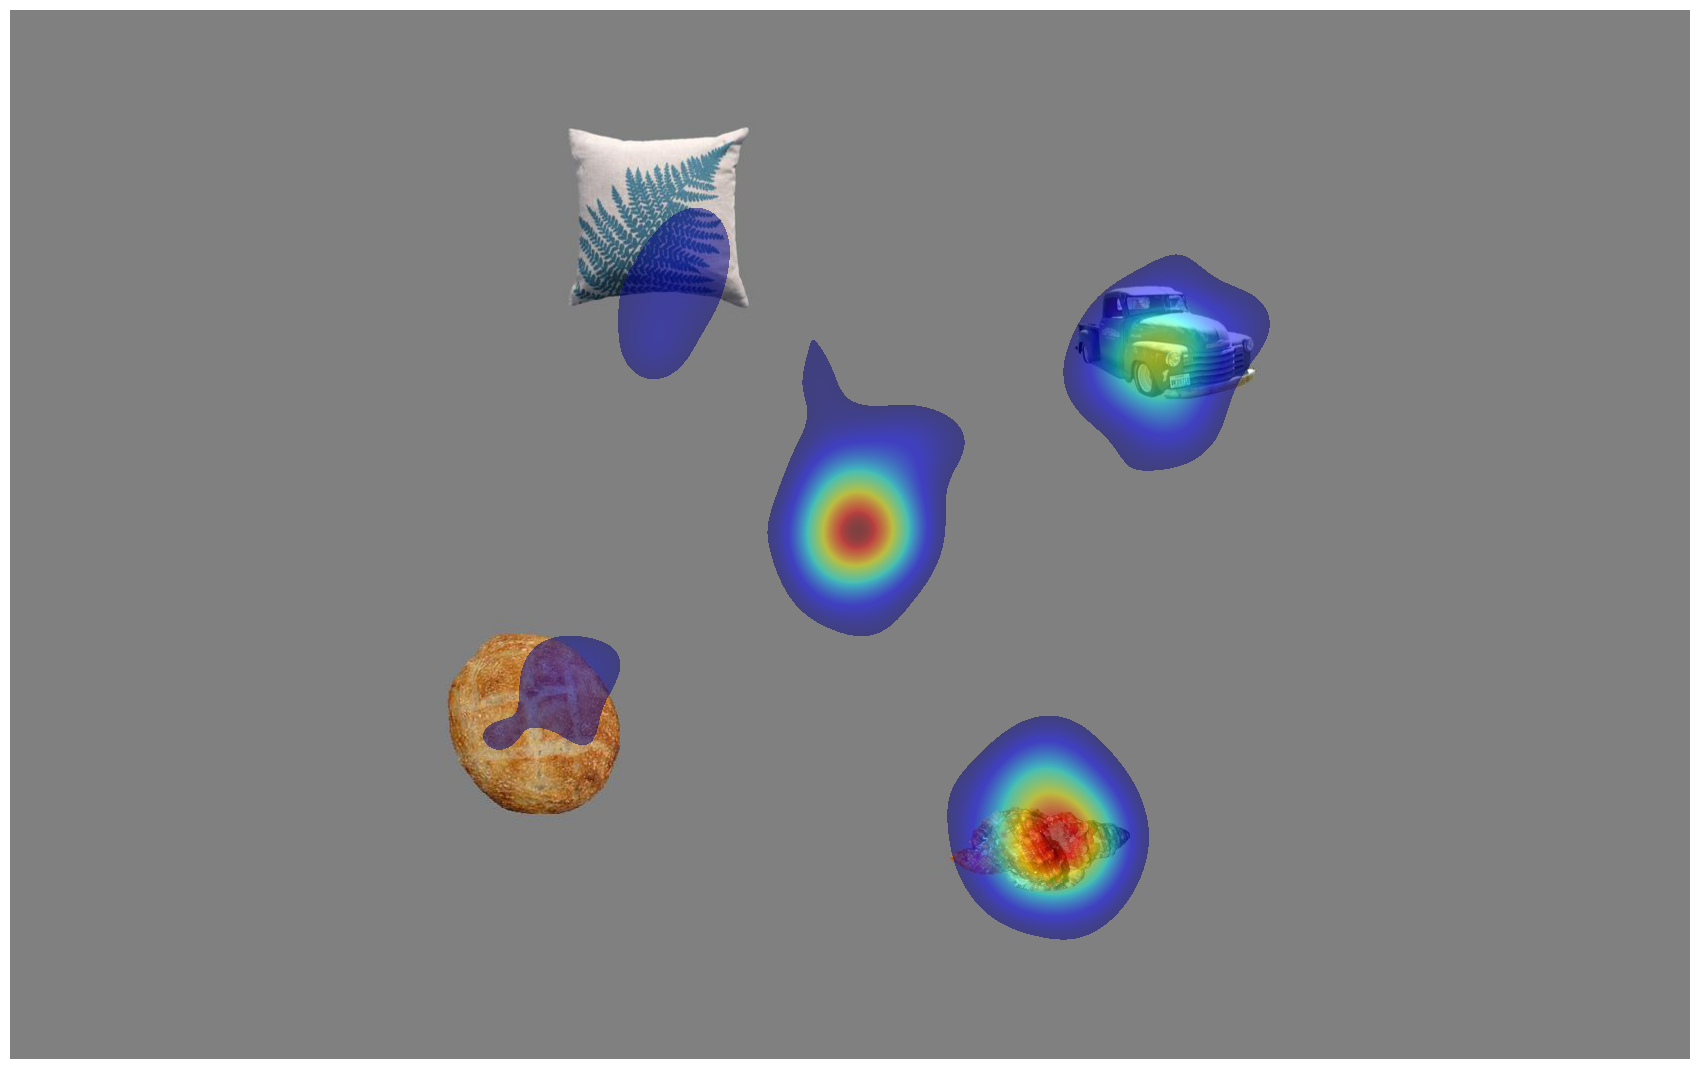

In [ ]:
from fixation_density import *

TAP = 'TA' # 'TP'

if TAP == 'Combined':
    fdictlist_TAP = [fd for fd in fdictlist if fd['ACC']]
    stimuli_info_TAP = stimuli_info_TP + stimuli_info_TA
elif TAP == 'TP':
    fdictlist_TAP = [fd for fd in fdictlist_TP if fd['ACC']]
    stimuli_info_TAP = stimuli_info_TP
elif TAP == 'TA':
    fdictlist_TAP = [fd for fd in fdictlist_TA if fd['ACC']]
    stimuli_info_TAP = stimuli_info_TA
else:
    raise NotImplementedError(f"Invalid TAP: {TAP}")

path_images = DIR_STIMULI 
path_save = '../figures/FDM/'

SAVE =False
ONLY_VISUALIZE = False
interest_period = None #None # True or None
verbose= False

plt.rcParams["figure.figsize"]=20,20
for i, trial in enumerate(stimuli_info_TAP):
    imgid = trial['display_idx']
    filename = d_imgid2imgfilename[imgid]
    imgpath = path_images + f'{filename}.png'
    
    # get fixdata under this trial id    
    fdictlist_TAP_trial_correct = list(filter(lambda x: x['IMAGE_ID'] == imgid and x['ACC'], fdictlist_TAP))
    
    # convert fixdata to tuple and aggregate across all participants  
    scanpath_tuple = []
    for scanpath in fdictlist_TAP_trial_correct:
        xs =[int(x) for x in scanpath['FIX_X']]
        ys =[int(y) for y in scanpath['FIX_Y']]
        ds =[int(y) for y in scanpath['FIX_DURATION']]
        if interest_period:
            xs = list(compress(xs, scanpath['FIX_IN_IP']))
            ys = list(compress(ys, scanpath['FIX_IN_IP']))
            ds = list(compress(scanpath['FIX_DURATION'], scanpath['FIX_IN_IP']))
        
        current_scanpath_tuple = list(zip(xs, ys, ds))
        scanpath_tuple.extend(current_scanpath_tuple)
 
    if verbose:
        print(f'{i}th image: num fixations used for visualization:', len(scanpath_tuple))
    
    
    # heatmap variables 
    display_height, display_width = 1050, 1680
    alpha = 0.5  #transparancy of the heatmap
    gaussianwh = 200
    gaussiansd = 30
    title = None

    if ONLY_VISUALIZE: 
        savefilename = None
    else: # save all fdm to the save folder
        savefilename = os.path.join(path_save, filename)
        
    # draw fdm
    fig = draw_heatmap(scanpath_tuple, (display_width, display_height), alpha=alpha, savefilename=savefilename, imagefile=imgpath, gaussianwh=gaussianwh, gaussiansd=gaussiansd, title=title)
    print(f'files saved {i+1}', end='\r')
    
    # get bbox
#     bboxes = human_bbox[imgid]
#     centers = []
#     for num, bi in enumerate(range(len(bboxes))): 
#         xmin, ymin, xmax, ymax = bboxes[bi] # first object
#         if VISUALIZE:
#             ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor = 'lime', fill=False, lw=5))
#         centers.append([int((xmin+xmax)/2), int((ymin+ymax)/2)])
#         ax.text(int((xmin+xmax)/2), int((ymin+ymax)/2), str(num), fontsize=100, color='red')

#     break

In [ ]:
#################
# fixation density maps
###############
SAVE =False
screen_centerx = 1680/2
screen_centery = 1050/2

TAP = 'TA'
fdictlist_TAP = list(filter(lambda x: x['CONDITION']==TAP,fdictlist))
if TAP=='TP':
    stimuli_info_TAP = list(filter(lambda x: x['condition']==TAP and x['cnn_search_acc'] and x['our_search_acc'], stimuli_info))
elif TAP=='TA':
    stimuli_info_TAP = list(filter(lambda x: x['condition']==TAP, stimuli_info))
print('condition: ', TAP,': # of stimuli :', len(stimuli_info_TAP))

imgids = []
mean_accs, mean_RTs, mean_AVERAGE_FIXDURs, mean_AVERAGE_SACAMPs, mean_NFIXs, mean_FIRST_FIXDURs, mean_FIRST_SAC_LATENCYs,  mean_FIRST_SAC_AMPLITUDEs, mean_NFIX2TARGETs, mean_TIME2TARGETs = [[] for i in range(10)]
target_budget_usage, our_entropy, cnn_entropy = [], [], []

for trial in stimuli_info_TAP:
    
    # model entropy
    our_entropy.append(trial['our_entropy'])
    cnn_entropy.append(trial['cnn_entropy'])
    
    
    # get fixation data
    imgid = trial['display_idx']
    imgids.append(imgid)
    fdictlist_TAP_trial = list(filter(lambda x: x['IMAGE_ID']==imgid, fdictlist_TAP))
    fdictlist_TAP_trial_correct = list(filter(lambda x: x['ACC'], fdictlist_TAP_trial))
    
    
    # trial acc
    n_subj = len(fdictlist_TAP_trial)
    n_subj_correct =  len(fdictlist_TAP_trial_correct)
    mean_accs.append(n_subj_correct/n_subj)
    
    # trial average eyemeasures
    mean_RTs.append(np.mean([fd['REACTION_TIME'] for fd in fdictlist_TAP_trial_correct]))
    mean_NFIXs.append(np.mean([len(fd['FIX_X']) for fd in fdictlist_TAP_trial_correct]))
    mean_AVERAGE_FIXDURs.append(np.mean([fd['AVERAGE_FIXATION_DURATION'] for fd in fdictlist_TAP_trial_correct]))
    mean_AVERAGE_SACAMPs.append(np.mean([fd['AVERAGE_SACCADE_AMPLITUDE'] for fd in fdictlist_TAP_trial_correct if not math.isnan(fd['AVERAGE_SACCADE_AMPLITUDE']) ]))
    

    # first saccade related eyemeasures # first item fixation made (outside of center)
#     mean_FIRST_SAC_LATENCYs.append(np.mean([fd['FIX_START'][0] for fd in fdictlist_TAP_trial_correct])) # this is literal first saccade has many zeros
    all_subj_latency = []
    all_subj_amplitude = []
    all_subj_firstfixdur = []
    for fd in fdictlist_TAP_trial_correct:    
        # get time of first roi visited
        for fixidx, value in enumerate(fd['ROI_LABELS']):
            if value != -1:
                break  # Stop when the first non -1 value is found

        first_objfix_latency = fd['FIX_START'][fixidx]
        first_objfix_duration = fd['FIX_DURATION'][0]
        first_objfix_amplitude = np.sqrt((fd['FIX_X'][fixidx]-screen_centerx)**2 +(fd['FIX_Y'][fixidx]-screen_centery)**2)
        
        if all(value == -1 for value in fd['ROI_LABELS']):
            continue
#             first_item_latency=0 # if person does not move outside of center but still got it correct
        
        all_subj_latency.append(first_objfix_latency)
        all_subj_amplitude.append(first_objfix_amplitude)
        all_subj_firstfixdur.append(first_objfix_duration)
        
    mean_FIRST_SAC_LATENCYs.append(np.mean(all_subj_latency))
    mean_FIRST_SAC_AMPLITUDEs.append(np.mean(all_subj_amplitude))
    mean_FIRST_FIXDURs.append(np.mean(all_subj_firstfixdur))
    
    # target related eyemeasures
    if TAP=='TP':
        target_locidx = trial['target_idx_in_objlist']

        nfix2target, time2target = [], []
        for fd in fdictlist_TAP_trial_correct:
            indices = np.where(np.array(fd['ROI_LABELS'])== target_locidx)[0]

            if indices.size > 0:
                first_index_of_target = indices[0]
                nfix2target.append(first_index_of_target)
                time2target.append(fd['FIX_START'][first_index_of_target])
            else:
                pass # there's no target in the labels
        
    
        
        mean_NFIX2TARGETs.append(np.mean(nfix2target))
        mean_TIME2TARGETs.append(np.mean(time2target))
    
        # model target budget usage
        target_budget_usage.append(trial['budget_usage'][trial['target_idx_in_objlist']])    
    

    
edf = pd.DataFrame()
                       
edf['imgid']= imgids
edf['our_entropy']=our_entropy
edf['cnn_entropy']=cnn_entropy
edf['target_budget_usage']=target_budget_usage if len(target_budget_usage)>0 else np.NaN

edf['mean_acc']=mean_accs
edf['mean_RT']=mean_RTs
edf['mean_NFIX']=mean_NFIXs

edf['mean_AVERAGE_FIXDUR']=mean_AVERAGE_FIXDURs
edf['mean_AVERAGE_SACAMP']=mean_AVERAGE_SACAMPs

edf['mean_FIRST_FIXDUR']=mean_FIRST_FIXDURs
edf['mean_FIRST_SAC_LATENCY']=mean_FIRST_SAC_LATENCYs
edf['mean_FIRST_SAC_AMPLITUDE']=mean_FIRST_SAC_AMPLITUDEs

edf['mean_NFIX2TARGET']=mean_NFIX2TARGETs if len(mean_NFIX2TARGETs)>0 else np.NaN
edf['mean_TIME2TARGET']= mean_TIME2TARGETs if len(mean_TIME2TARGETs)>0 else np.NaN

if SAVE:
    edf.to_csv(f'results/{TAP}_entropy_and_gaze.csv', index=False)
    print('saved to disk')

condition:  TA : # of stimuli : 100


# Entropy analysis

In [59]:
edf['mean_RT'].mean()

932.458259951671

In [60]:
edf['mean_RT'].std()

169.32098711657144

0.9623434343434344

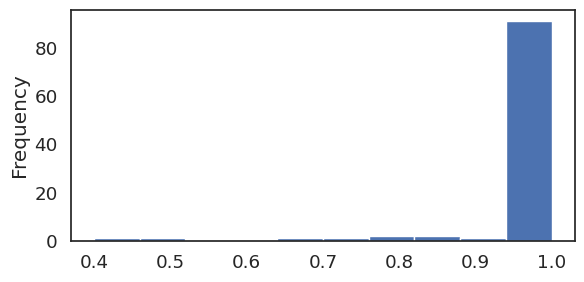

In [61]:
# average acc per trial
plt.rcParams["figure.figsize"]=6.5,3
edf['mean_acc'].plot(kind='hist')
edf['mean_acc'].mean()

In [62]:
# find rows with NaN values
nan_rows = edf[edf.isnull().any(axis=1)]
edf.isnull().any()

imgid                       False
our_entropy                 False
cnn_entropy                 False
target_budget_usage          True
mean_acc                    False
mean_RT                     False
mean_NFIX                   False
mean_AVERAGE_FIXDUR         False
mean_AVERAGE_SACAMP         False
mean_FIRST_SAC_LATENCY      False
mean_FIRST_SAC_AMPLITUDE    False
mean_NFIX2TARGET             True
mean_TIME2TARGET             True
dtype: bool

0.03287598836146778 0.7479324527697832


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


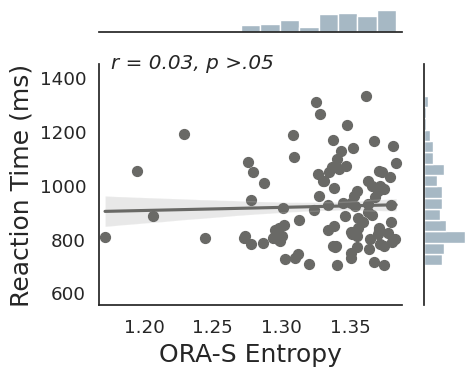

-0.219949022969729 0.02954249010399561


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


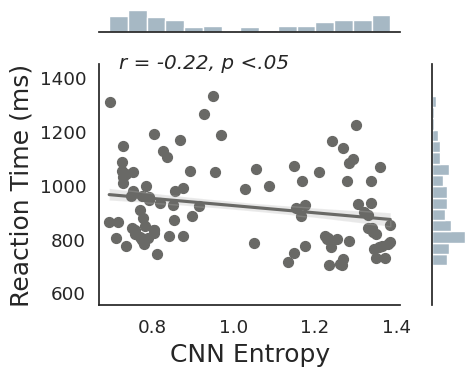

0.026446269390980347 0.7960281418424654


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


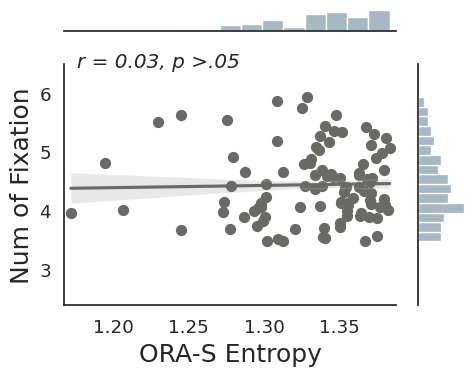

-0.12215147295836737 0.2308330801453923


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


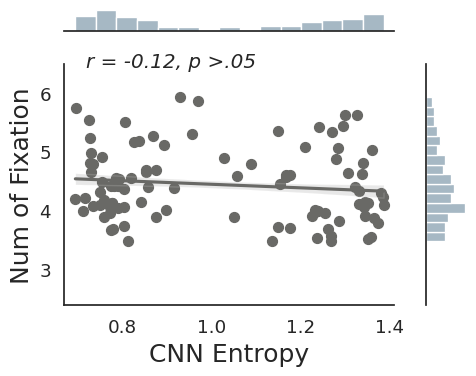

-0.2624993481647574 0.008668331040929879


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


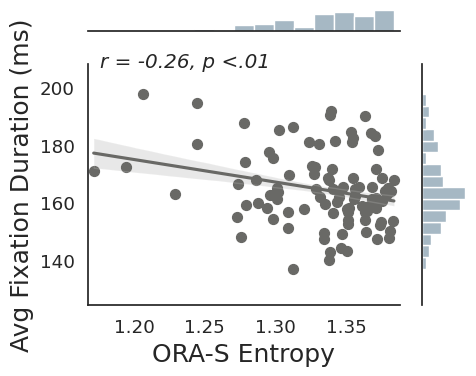

-0.08608228373174438 0.3968813219479928


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


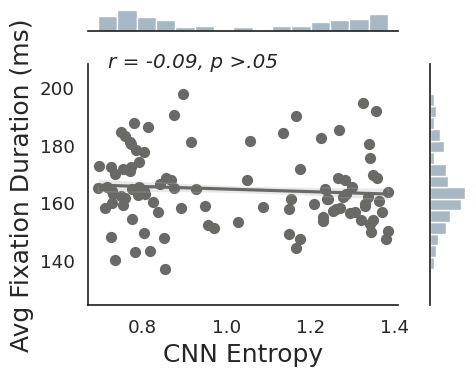

0.16871895372528295 0.0967675295263459


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


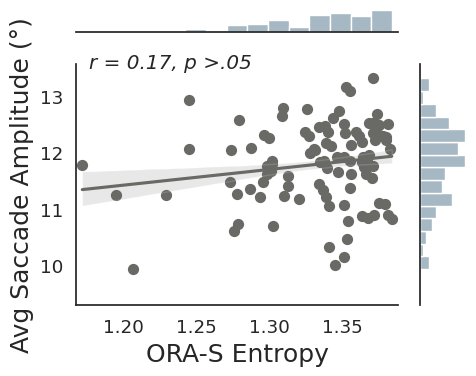

-0.18479890355215567 0.06850547784676234


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


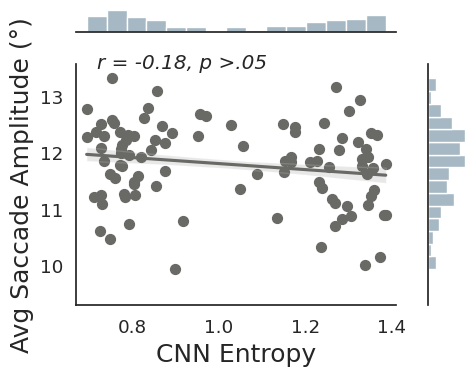

-0.16145966997091935 0.11035600772762622


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


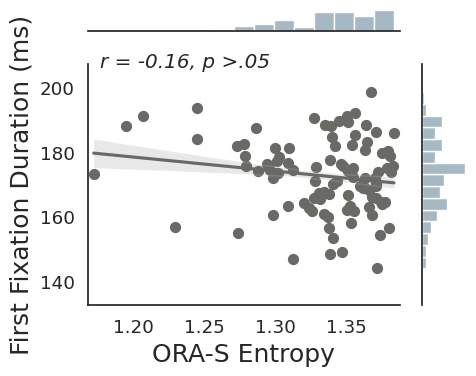

0.12254787166865266 0.22688926875778206


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


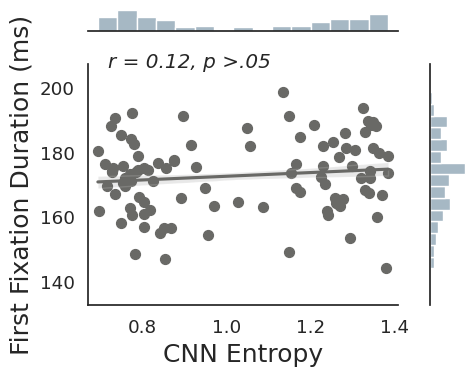

-0.19060233901976584 0.05879178007150765


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


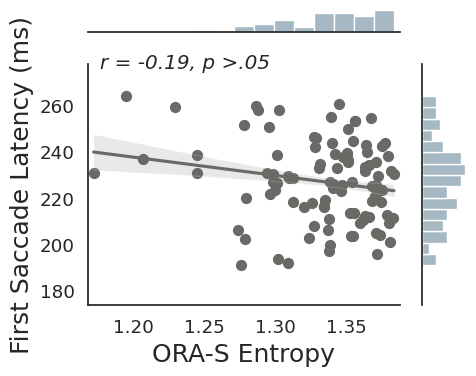

0.02865248549749297 0.7783071851340438


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


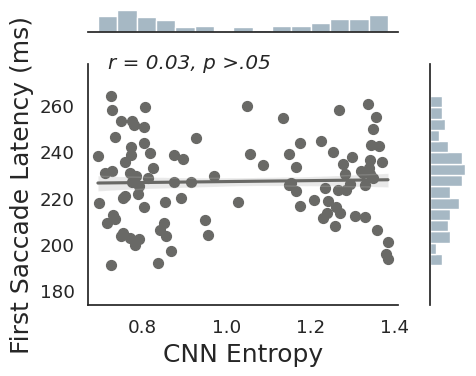

-0.021115086030549082 0.8373483398870999


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


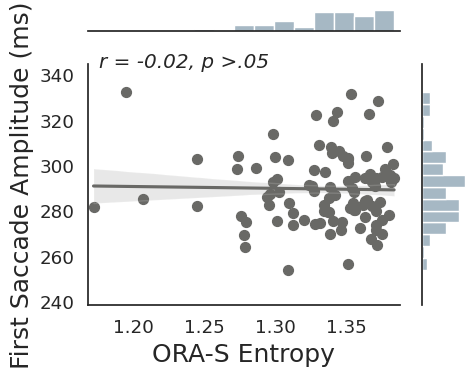

-0.01678023425625538 0.8704120192871313


/tmp/ipykernel_2211118/821577228.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


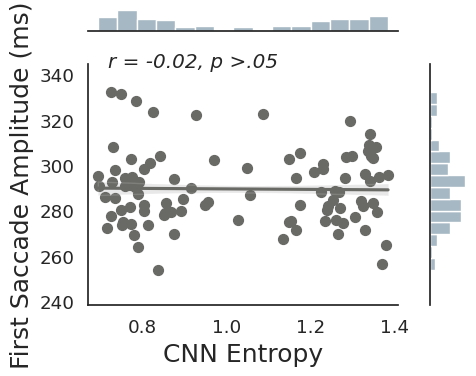

In [68]:
# we can also add number of return fixations
measure2label = {}
measure2label['mean_RT'] = 'Reaction Time (ms)'
measure2label['mean_NFIX'] = 'Num of Fixation'
measure2label['mean_AVERAGE_FIXDUR'] = 'Avg Fixation Duration (ms)'
measure2label['mean_AVERAGE_SACAMP'] = 'Avg Saccade Amplitude (°)'

measure2label['mean_FIRST_FIXDUR'] = 'First Fixation Duration (ms)'
measure2label['mean_FIRST_SAC_LATENCY'] = 'First Saccade Latency (ms)'
measure2label['mean_FIRST_SAC_AMPLITUDE'] = 'First Saccade Amplitude (ms)'

measure2label['mean_NFIX2TARGET'] = 'Num Fix to Target'
measure2label['mean_TIME2TARGET'] = 'Time to Target (ms)'

if TAP=='TP':
    measurelist = ['mean_RT', 'mean_NFIX','mean_AVERAGE_FIXDUR','mean_AVERAGE_SACAMP', 
                   'mean_FIRST_FIXDUR', 'mean_FIRST_SAC_LATENCY', 'mean_FIRST_SAC_AMPLITUDE', 
                   'mean_NFIX2TARGET','mean_TIME2TARGET']
elif TAP =='TA':
    measurelist = ['mean_RT', 'mean_NFIX','mean_AVERAGE_FIXDUR','mean_AVERAGE_SACAMP', 
                   'mean_FIRST_FIXDUR', 'mean_FIRST_SAC_LATENCY', 'mean_FIRST_SAC_AMPLITUDE']

for Y_MEASURE in measurelist:
    for X_MEASURE in ['our_entropy', 'cnn_entropy']:
        xlabel = 'CNN Entropy' if X_MEASURE == 'cnn_entropy' else 'ORA-S Entropy'
        ylabel = measure2label[Y_MEASURE]
        data = edf.copy()

        # Calculate the mean and standard deviation of the column
        mean_value = data[Y_MEASURE].mean()
        std_value = data[Y_MEASURE].std()

        # Define the number of standard deviations (SD) for filtering
        num_sd = 2.5

        # Filter the DataFrame to keep rows within the specified range
        data = data[(data[Y_MEASURE] >= mean_value - num_sd * std_value) &
                          (data[Y_MEASURE] <= mean_value + num_sd * std_value)]

        corr = pearsonr(data[X_MEASURE], data[Y_MEASURE])[0]
        pvalue =pearsonr(data[X_MEASURE], data[Y_MEASURE])[1]
        print(pearsonr(data[X_MEASURE], data[Y_MEASURE])[0], pvalue)

        if pvalue<0.001:
            pvalue='p <.001'
        elif pvalue <0.01:
            pvalue='p <.01'
        elif pvalue <0.05:
            pvalue='p <.05'
        else:
            pvalue='p >.05'


        sns.set(style='white', font_scale=1.2)
        # sns.set(rc={"xtick.bottom" : True})

        ylim= (round(data[Y_MEASURE].min())-data[Y_MEASURE].std(), round(data[Y_MEASURE].max())+0.8*data[Y_MEASURE].std())
        xlim= (data[X_MEASURE].min()-0.1*data[X_MEASURE].std(), data[X_MEASURE].max()+0.1*data[X_MEASURE].std())

        g = sns.JointGrid(data=data, x=X_MEASURE , xlim=xlim, ylim=ylim, y=Y_MEASURE, height=5) #xlim=(1, 16), ylim=(900, 1600) #
        g = g.plot_joint(sns.regplot, color="#696966", x_estimator=np.mean, x_ci=68, ci=68) # if 68-> SE
        g = g.plot_marginals(sns.histplot, kde=False, bins=15, color="xkcd:bluey grey")
        g.ax_joint.text(xlim[0]+0.2*data[X_MEASURE].std(), ylim[1]-0.1*data[Y_MEASURE].std(), f'r = {corr:.2f}, {pvalue}', fontstyle='italic')
        g.fig.set_size_inches((5, 4))

        # Set x and y-axis labels
        g.set_axis_labels(xlabel=xlabel, ylabel=ylabel, fontsize=18)

        # Set x-axis ticks and tick labels
        # minorLocator = MultipleLocator(1)
        # majorLocator = MultipleLocator(3)
        # g.ax_joint.xaxis.set_minor_locator(minorLocator)
        # g.ax_joint.xaxis.set_major_locator(majorLocator)
        # # g.ax_joint.set_xlim(range(0, 15))
        # g.ax_joint.set_xticks(range(-1, 17, 3))
        # g.ax_joint.set_xticklabels(['','1', '2', '3', '4', '5'], fontsize=15)

        plt.tight_layout()
        plt.savefig(f'../figures/entropy/{TAP}-{X_MEASURE}-{Y_MEASURE}.pdf', dpi=300,  bbox_inches='tight')
        plt.show()
        plt.close()

# accs

In [ ]:
# # Model ACC when clean and blur
# SAVE= False
# data_clean= np.array([0.908, 0.728])*100 # clean, our-cnn
# data_foveated = np.array([0.781, 0.645])*100 # foveated
# data_blur = np.array([0.7, 0.432])*100 # blur

# categories = ['ORA-S', 'Detector']
# x = np.arange(len(categories))


# # Create the bar plot with error bars
# plt.rcParams["figure.figsize"]=5, 3.5

# # Set the width of the bars
# bar_width = 0.25

# # Create the bar chart
# fig, ax = plt.subplots()
# bar1 = ax.bar(x - bar_width, data_clean, bar_width, label='Clean', color='blue',linewidth=1, edgecolor='black')
# bar2 = ax.bar(x, data_foveated , bar_width, label='Foveated Blur', color='darkgrey', linewidth=1,edgecolor='black')
# bar3 = ax.bar(x + bar_width, data_blur, bar_width, label='Gaussian Blur', color='white', linewidth=1,edgecolor='black' )

# # Add labels, title, and legend
# ax.set_xlabel('Model')
# ax.set_xlim(-0.6,1.6)

# ax.set_ylabel('Greedy Accuracy (%)')
# ax.set_ylim(0,100)
# ax.set_xticks(x)
# ax.set_xticklabels(categories)

# ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
# # Show the plot

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)

# # foveated blur
# # uniform blur

# # plt.tight_layout()
# if SAVE:
#     plt.savefig(f'figures/model_accuracy.pdf', dpi=300,  bbox_inches='tight')
# plt.show()